In [1]:
import numpy as np
from numba import jit
from numpy.random import default_rng as rg
rng = rg(12345)
from tqdm import tqdm
import sys
sys.path.append('../core')
%matplotlib inline
import math

In [2]:
import torch
torch.manual_seed(0)
import torch.optim as optim

In [3]:
from FLDojo import dojo
from FL import FL
from DNN_R import DNN
from display2 import*

205.826229518


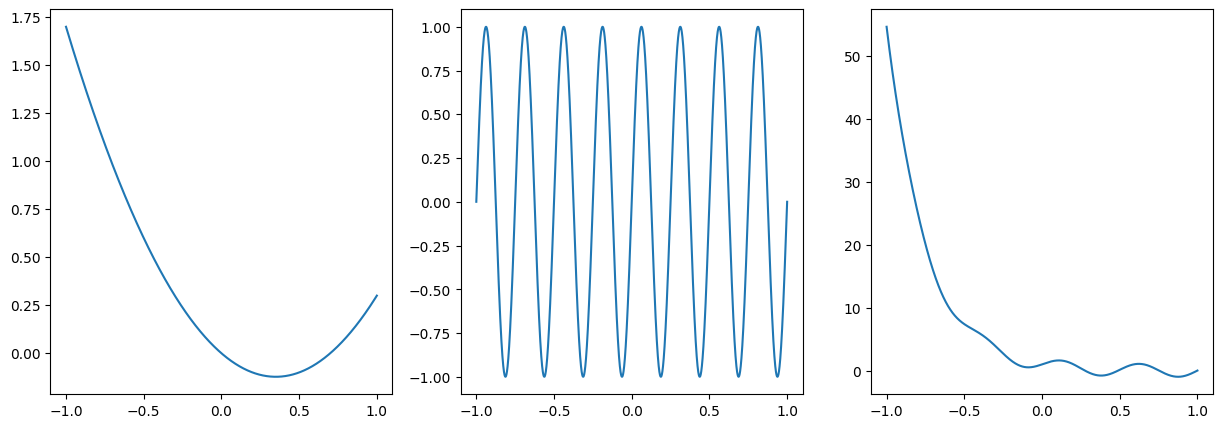

In [4]:
Xs = np.linspace(-1,1,40000)
Ys0 = Xs**2 - 0.7*Xs
# derivative is 2x - 0.7, which has a absval max of 2.7 (which is the Lipshitz constant)
Ys1 = np.sin(Xs*8*np.pi)
# note derivative is 8 pi cos(8 pi x), which has a max of 8 pi (which is the Lipshitz constant)
Ys2 = np.sin(Xs*4*np.pi) + np.exp(-4*Xs)
print(np.max(np.abs(4*np.pi*np.cos(4*np.pi*Xs) - 4*np.exp(-4*Xs))))
# derivative has a max of ~205 (which is the Lipshitz constant)
from matplotlib import pyplot as plt
fig,axs = plt.subplots(1,3,figsize=(15,5))
axs[0].plot(Xs,Ys0)
axs[1].plot(Xs,Ys1)
axs[2].plot(Xs,Ys2)

# We will use the same network for all three functions
ks = [2.7,8*np.pi,205]
dnn_sizes = [1,102,101,1] # so # of weights is 102*1 + 102*102 + 102*1 = 10608  
fl_sizes = [1,100,100] # so # of weights is  1*a + a*1 + a*a + a*1 = 10300, for a = 100

fl_sizes2 = [1,25,25] # so # of weights is  1*a + a*1 + a*a + a*1 = 700, for a = 25
dnn_sizes2 = [1,26,26,1] # so # of weights is 26*1 + 26*26 + 26*1 = 728
# a three layer nn can represent any multivariate function (continuous or discontinuous) https://arxiv.org/abs/2012.03016


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
p = np.random.permutation(len(Xs))
Xs = Xs[p]
X = torch.from_numpy(Xs).float().unsqueeze(1).to(device)
split = 0.75
train_X = X[:int(split*len(X))]
test_X = X[int(split*len(X)):]

def update_y(Ys):
    y = torch.from_numpy(Ys[p]).float().unsqueeze(1).to(device)
    train_y = y[:int(split*len(y))]
    test_y = y[int(split*len(y)):]
    return train_y, test_y

In [6]:
D = dojo()
D.epochs=1000
D.max_batch_size=train_X.shape[0]
opt = lambda x: optim.Adam(x, lr=0.00001) # Adam better than SGD and AdamW in quick tests.

# Sine DNN

100%|██████████| 1000/1000 [00:04<00:00, 204.85it/s]


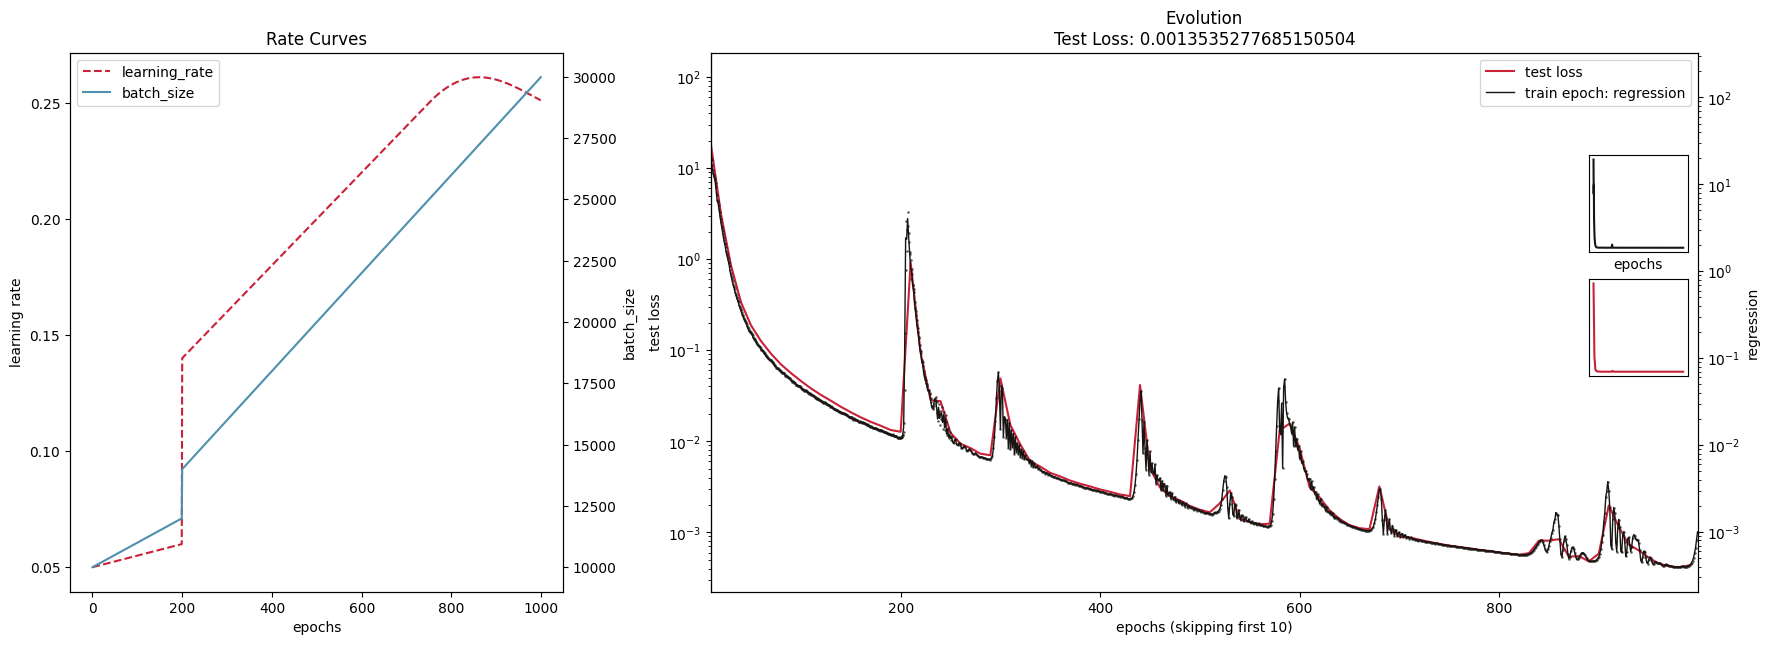

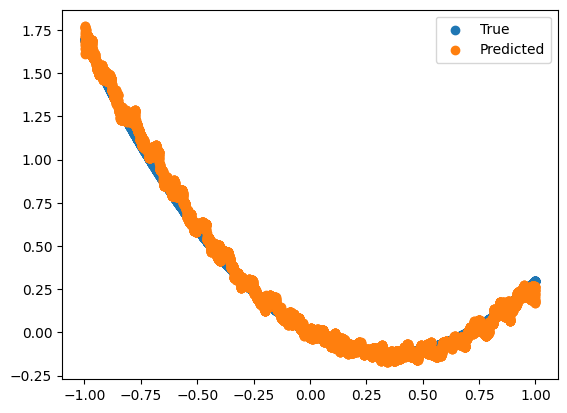

In [20]:
train_y,test_y = update_y(Ys0)

act = lambda x: torch.sin(x)
ins = [lambda x: torch.nn.init.uniform_(x, a=-math.sqrt(6/n), b=math.sqrt(6/n)) for n in dnn_sizes]
ins[0] = lambda x: torch.nn.init.constant_(x, 30)

net = DNN(device, dnn_sizes, opttype=opt, act = act, bias=True, initializers=ins) # expect 1.6% error rate
report = D.train(net, train_X, train_y, test_X, test_y, start_batch_size=10000)
ecran(net, test_X, test_y, report, classification=False)
plt.scatter(test_X.detach().cpu().numpy(),test_y.detach().cpu().numpy(),label='True')
plt.scatter(test_X.detach().cpu().numpy(),net(test_X).detach().cpu().numpy(),label='Predicted')
plt.legend()
plt.show()

100%|██████████| 1000/1000 [00:03<00:00, 257.66it/s]


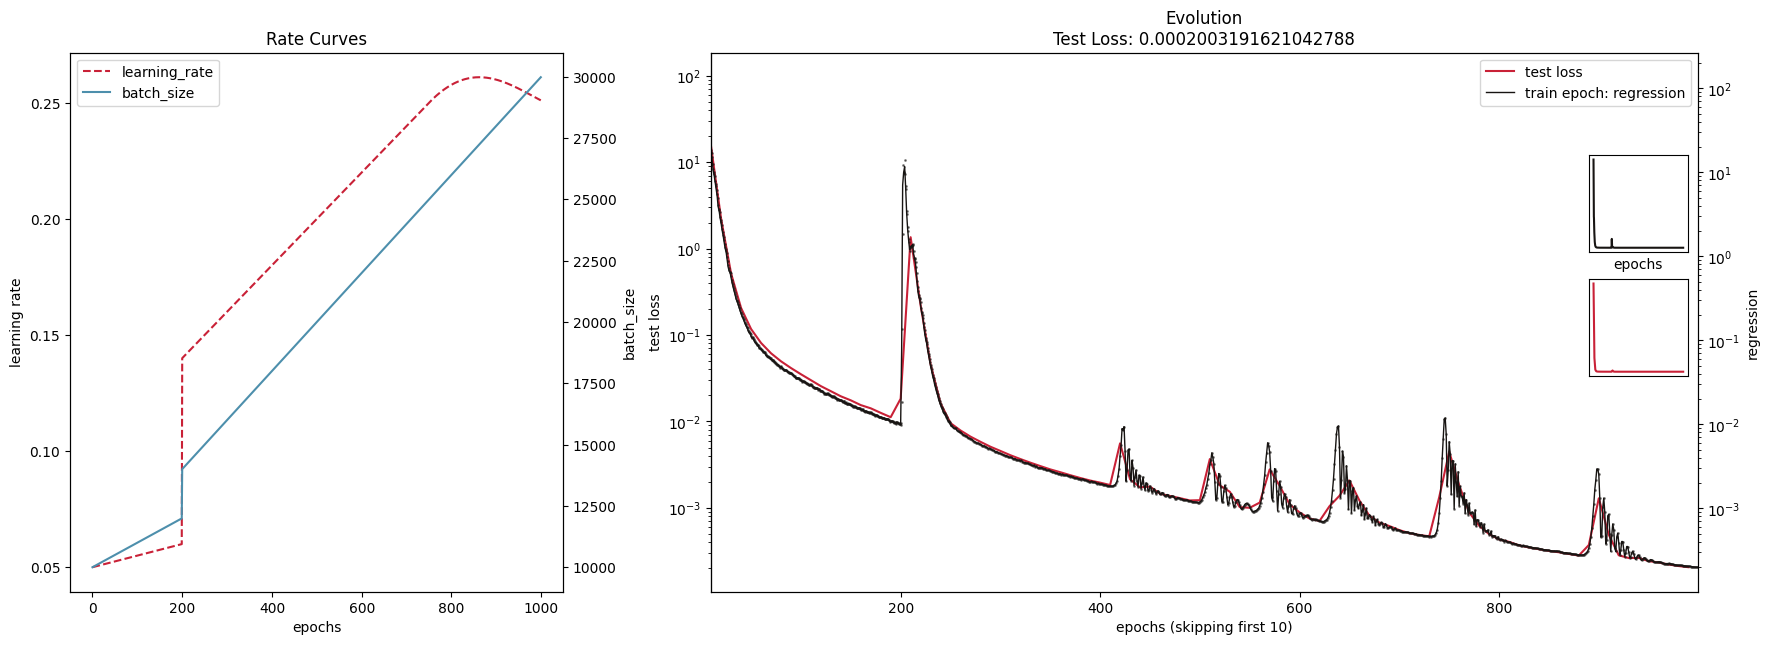

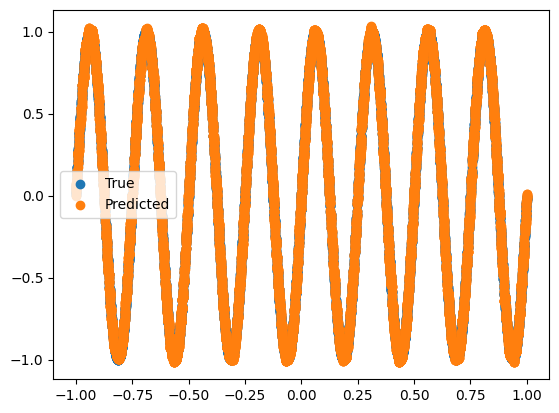

In [21]:
train_y,test_y = update_y(Ys1)

act = lambda x: torch.sin(x)
ins = [lambda x: torch.nn.init.uniform_(x, a=-math.sqrt(6/n), b=math.sqrt(6/n)) for n in dnn_sizes]
ins[0] = lambda x: torch.nn.init.constant_(x, 30)

net = DNN(device, dnn_sizes, opttype=opt, act = act, bias=True, initializers=ins) # expect 1.6% error rate
report = D.train(net, train_X, train_y, test_X, test_y, start_batch_size=10000)
ecran(net, test_X, test_y, report, classification=False)
plt.scatter(test_X.detach().cpu().numpy(),test_y.detach().cpu().numpy(),label='True')
plt.scatter(test_X.detach().cpu().numpy(),net(test_X).detach().cpu().numpy(),label='Predicted')
plt.legend()
plt.show()

100%|██████████| 1000/1000 [00:04<00:00, 229.95it/s]


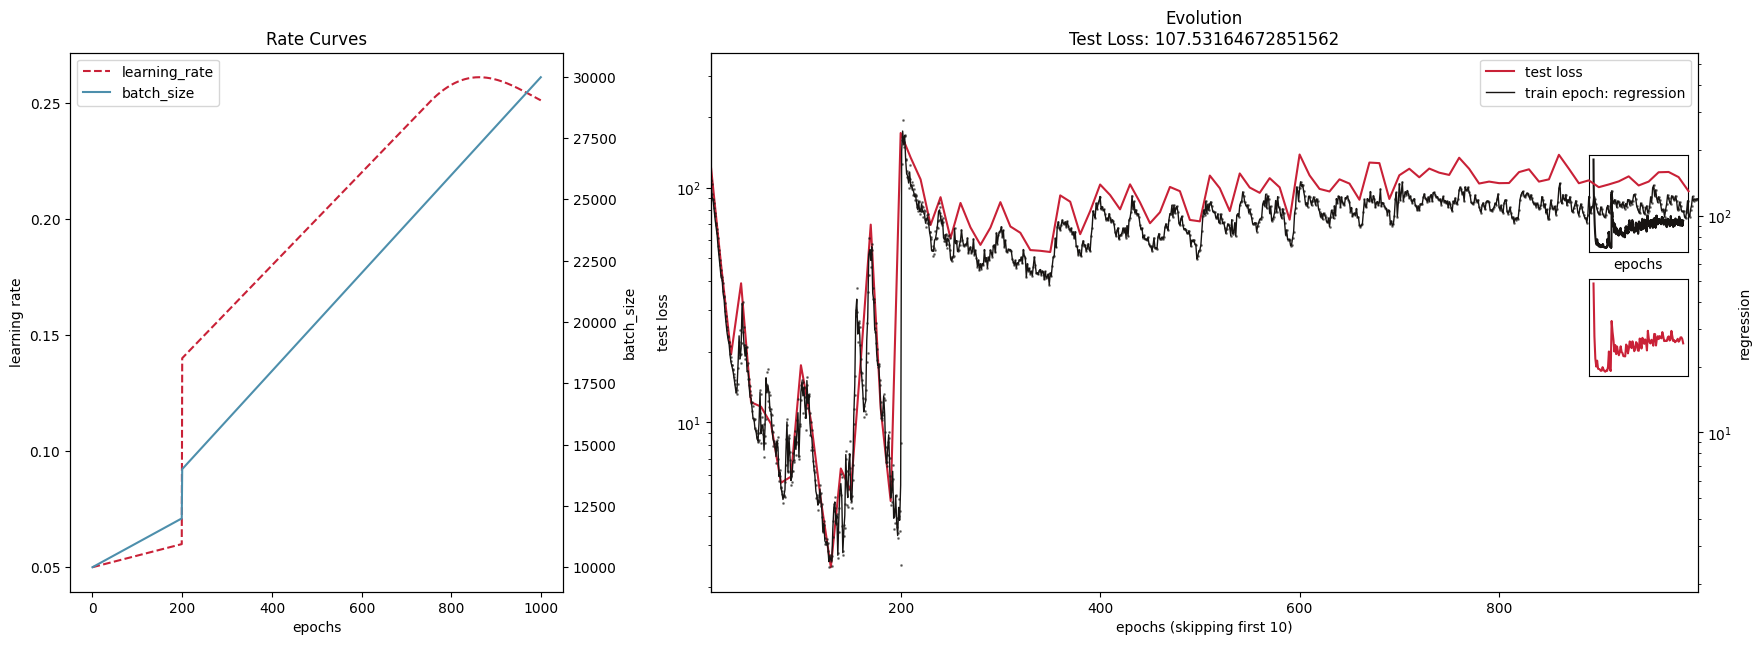

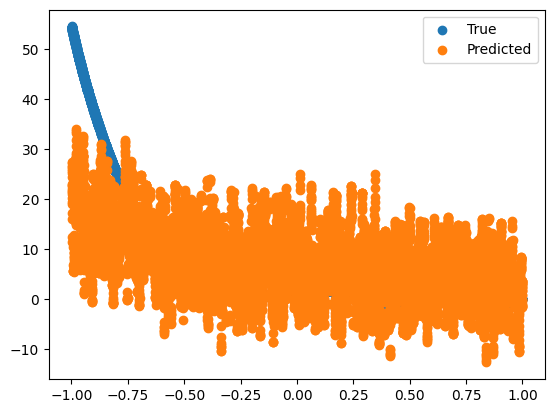

In [27]:
train_y,test_y = update_y(Ys2)

act = lambda x: torch.sin(x)
ins = [lambda x: torch.nn.init.uniform_(x, a=-math.sqrt(6/n), b=math.sqrt(6/n)) for n in dnn_sizes]
ins[0] = lambda x: torch.nn.init.constant_(x, 30)

net = DNN(device, dnn_sizes, opttype=opt, act = act, bias=True, initializers=ins) # expect 1.6% error rate
report = D.train(net, train_X, train_y, test_X, test_y, start_batch_size=10000)
ecran(net, test_X, test_y, report, classification=False)
plt.scatter(test_X.detach().cpu().numpy(),test_y.detach().cpu().numpy(),label='True')
plt.scatter(test_X.detach().cpu().numpy(),net(test_X).detach().cpu().numpy(),label='Predicted')
plt.legend()
plt.show()

# Log-normal DNN

100%|██████████| 1000/1000 [00:06<00:00, 153.05it/s]


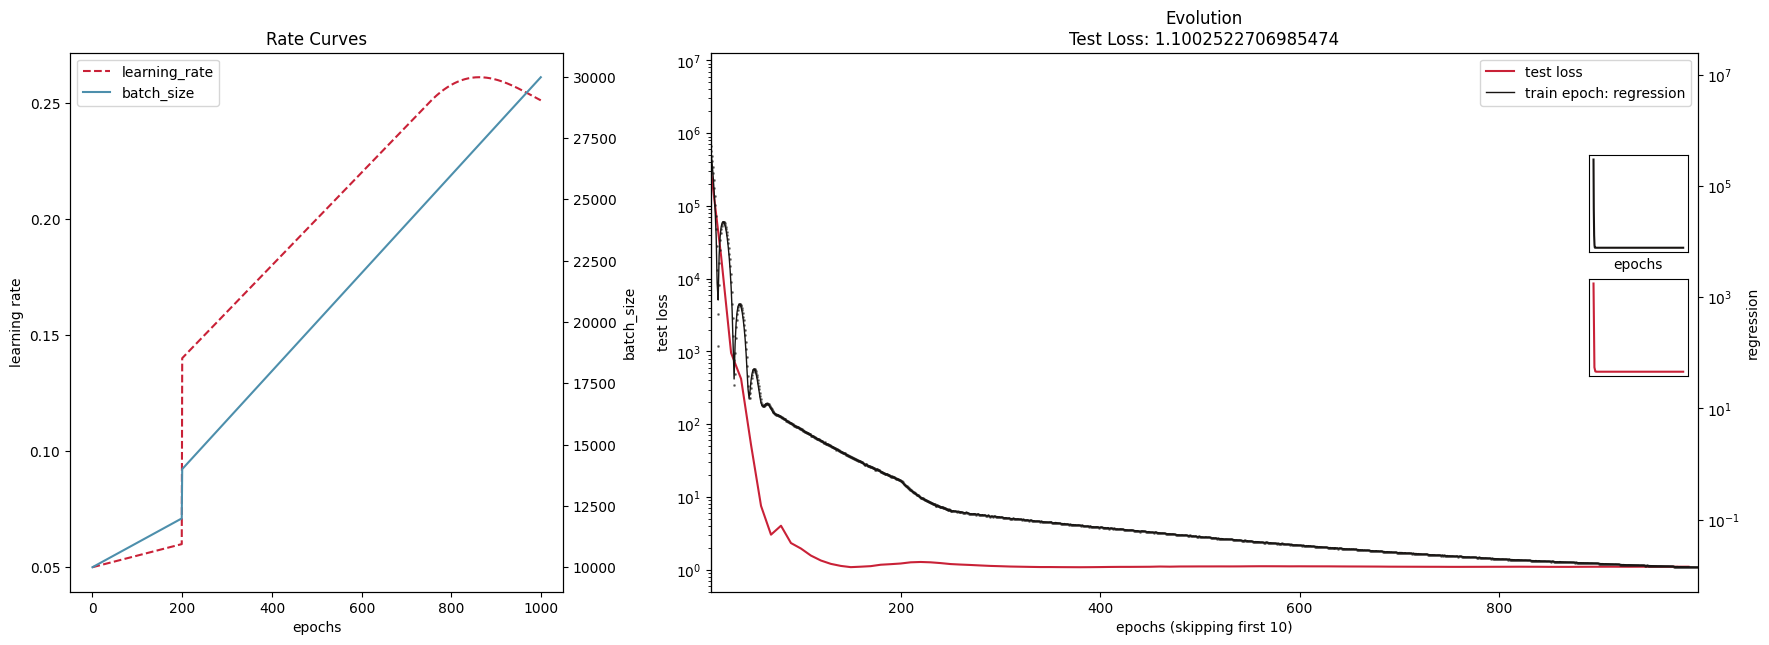

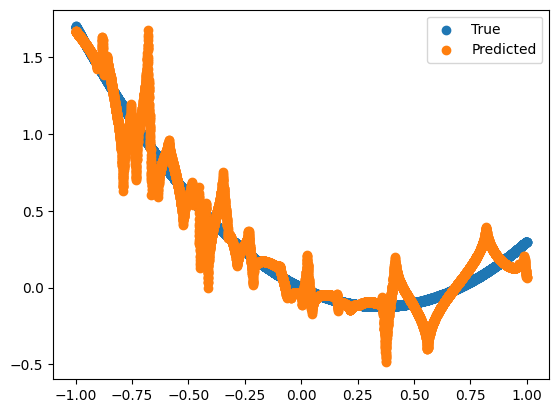

In [73]:
train_y,test_y = update_y(Ys0)

act = lambda x: torch.exp(0.5*torch.log(torch.abs(x))) + 1
def setup(x):
     x.data = torch.exp(torch.randn(x.size(), device=x.device))
     return x
ins = [lambda x: setup(x)]*len(dnn_sizes)
# ins[0] = lambda x: torch.nn.init.constant_(x, 30)

net = DNN(device, dnn_sizes, opttype=opt, act = act, bias=True, initializers=ins) # expect 1.6% error rate
report = D.train(net, train_X+1, train_y, test_X, test_y, start_batch_size=10000) # add 10 to avoid log(0) - since this is lognormal
ecran(net, test_X, test_y, report, classification=False)
plt.scatter(test_X.detach().cpu().numpy(),test_y.detach().cpu().numpy(),label='True')
plt.scatter(test_X.detach().cpu().numpy(),net(test_X+1).detach().cpu().numpy(),label='Predicted')
plt.legend()
plt.show()

100%|██████████| 1000/1000 [00:07<00:00, 133.99it/s]


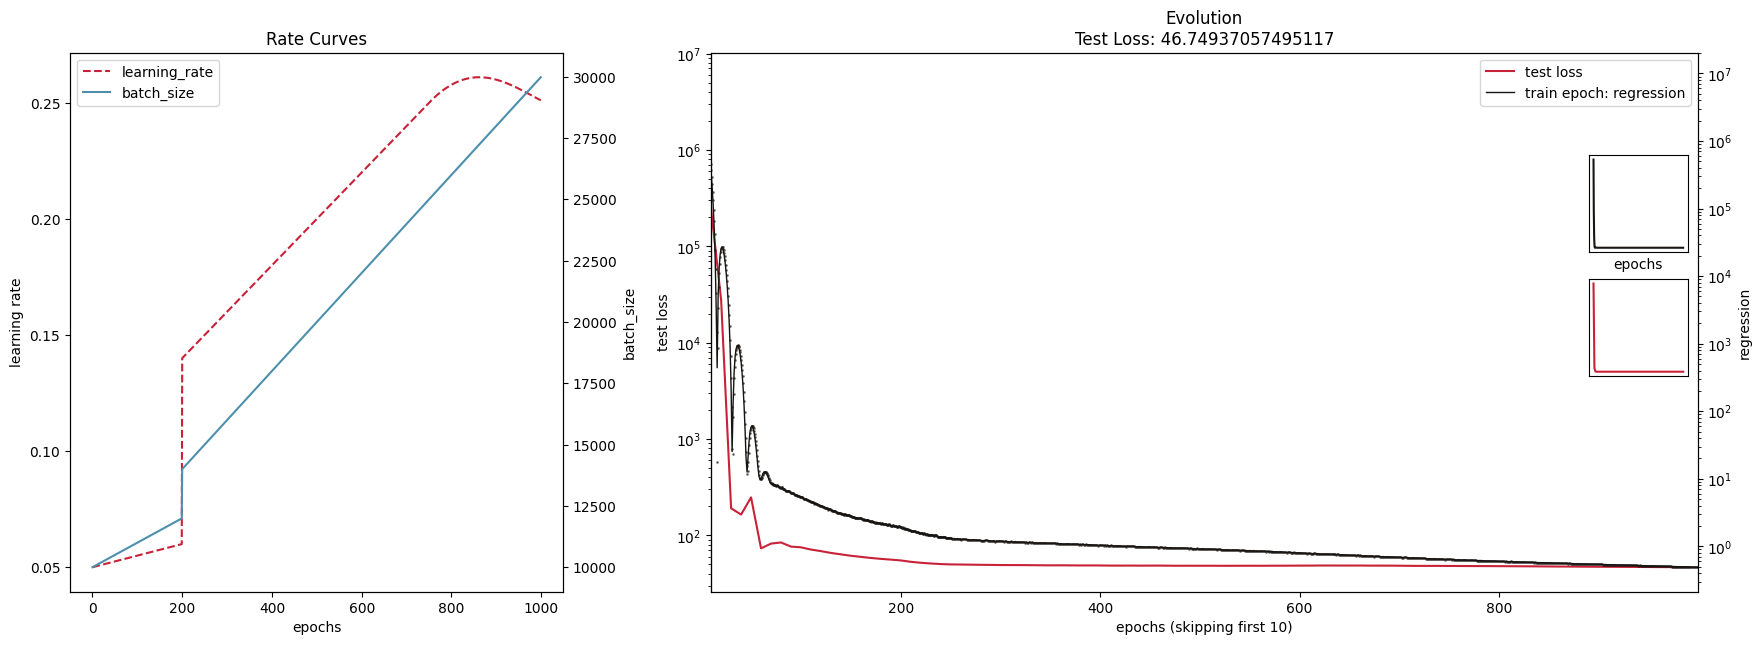

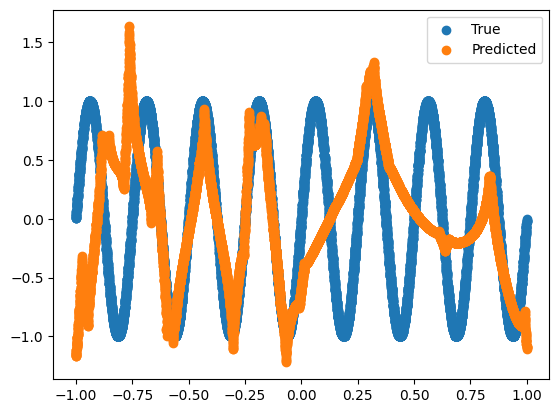

In [37]:
train_y,test_y = update_y(Ys1)

act = lambda x: torch.exp(0.5*torch.log(torch.abs(x))) + 1
def setup(x):
     x.data = torch.exp(torch.randn(x.size(), device=x.device))
     return x
ins = [lambda x: setup(x)]*len(dnn_sizes)
# ins[0] = lambda x: torch.nn.init.constant_(x, 30)

net = DNN(device, dnn_sizes, opttype=opt, act = act, bias=True, initializers=ins) # expect 1.6% error rate
report = D.train(net, train_X+1, train_y, test_X, test_y, start_batch_size=10000) # add 10 to avoid log(0) - since this is lognormal
ecran(net, test_X, test_y, report, classification=False)
plt.scatter(test_X.detach().cpu().numpy(),test_y.detach().cpu().numpy(),label='True')
plt.scatter(test_X.detach().cpu().numpy(),net(test_X+1).detach().cpu().numpy(),label='Predicted')
plt.legend()
plt.show()

100%|██████████| 1000/1000 [00:05<00:00, 172.58it/s]


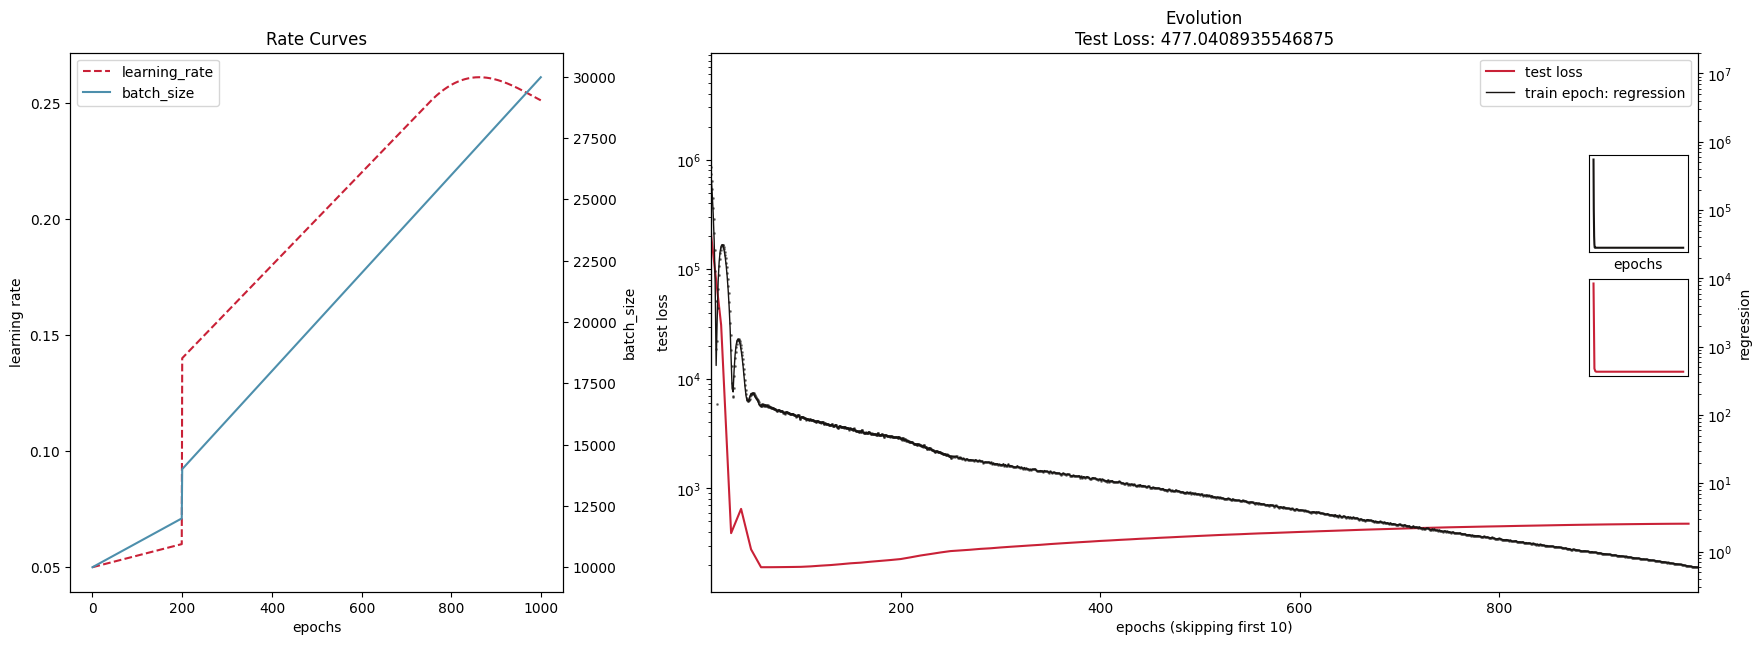

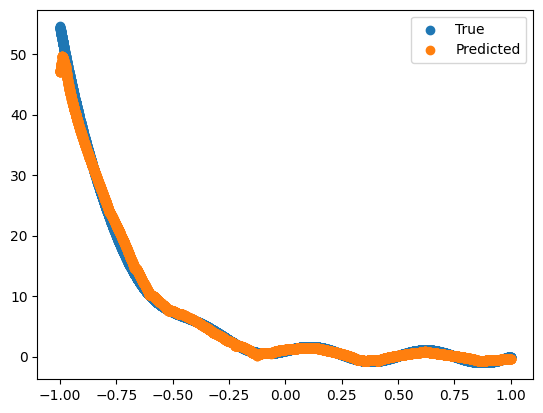

In [35]:
train_y,test_y = update_y(Ys2)

act = lambda x: torch.exp(0.5*torch.log(torch.abs(x))) + 1
def setup(x):
     x.data = torch.exp(torch.randn(x.size(), device=x.device))
     return x
ins = [lambda x: setup(x)]*len(dnn_sizes)
# ins[0] = lambda x: torch.nn.init.constant_(x, 30)

net = DNN(device, dnn_sizes, opttype=opt, act = act, bias=True, initializers=ins) # expect 1.6% error rate
report = D.train(net, train_X+1, train_y, test_X, test_y, start_batch_size=10000) # add 10 to avoid log(0) - since this is lognormal
ecran(net, test_X, test_y, report, classification=False)
plt.scatter(test_X.detach().cpu().numpy(),test_y.detach().cpu().numpy(),label='True')
plt.scatter(test_X.detach().cpu().numpy(),net(test_X+1).detach().cpu().numpy(),label='Predicted')
plt.legend()
plt.show()

# log normal DNN again (improved)

100%|██████████| 1000/1000 [00:05<00:00, 184.95it/s]


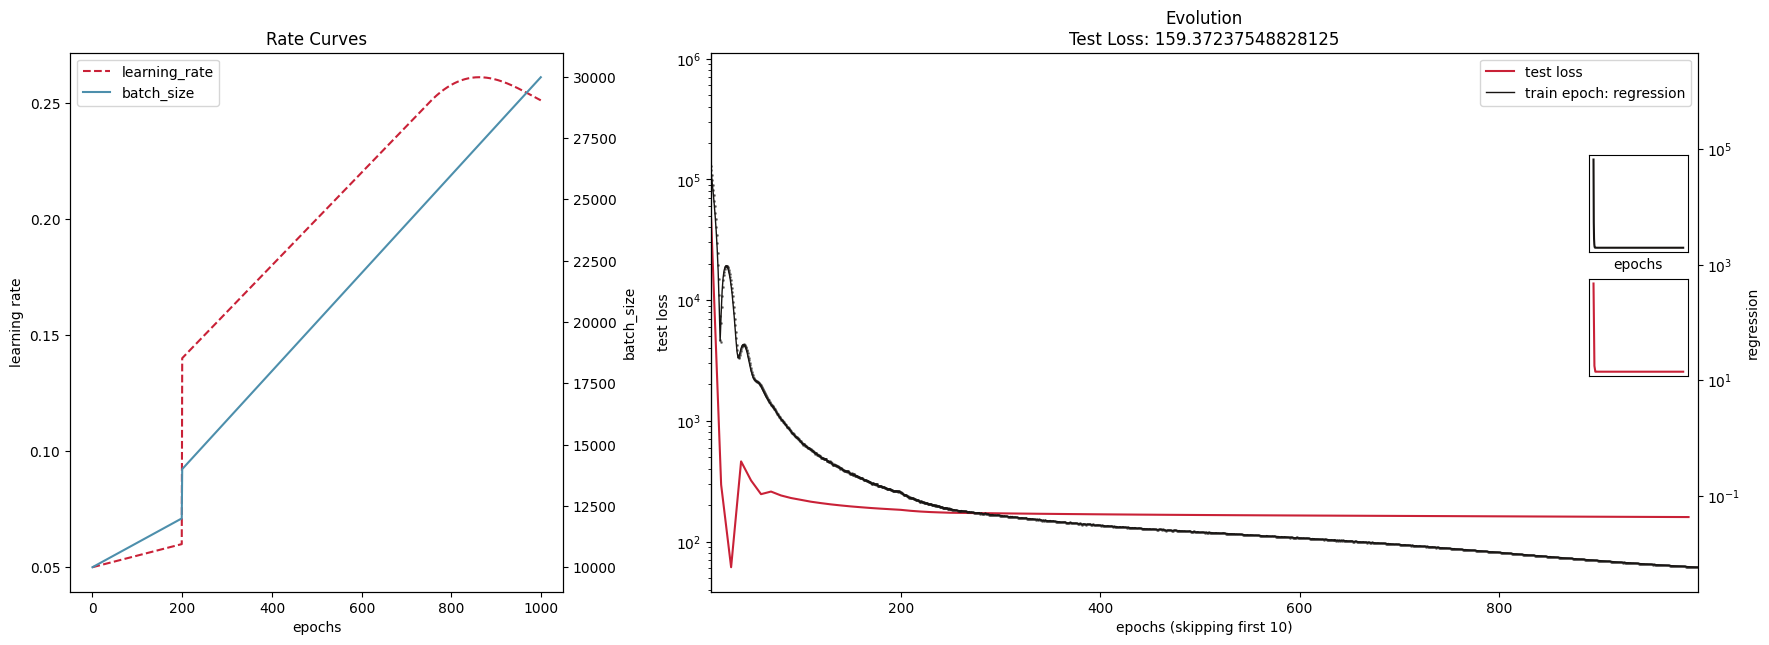

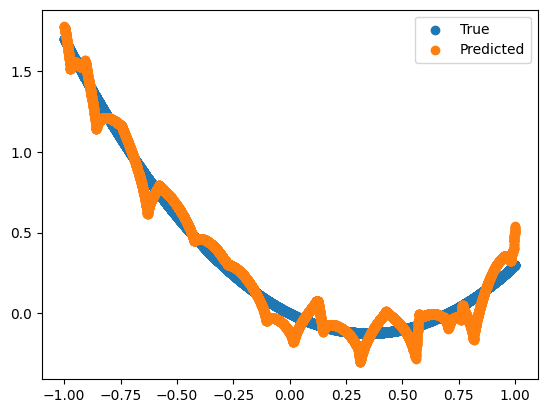

In [31]:
train_y,test_y = update_y(Ys0)

act = [lambda x: math.exp(-1)*torch.pow(torch.abs(x),1/math.sqrt(n*2)) for n in dnn_sizes] # std 1, 1 -> sqrt(2), (accounting for number of samples)
def setup(x):
     x.data = torch.exp(3+torch.minimum(torch.randn(x.size(), device=x.device) - 3,0.0*x)) # mean 0 , std 1, capped at 3sigma at top.
     return x
ins = [lambda x: setup(x)]*len(dnn_sizes)
# ins[0] = lambda x: torch.nn.init.constant_(x, 30)

net = DNN(device, dnn_sizes, opttype=opt, act = act, bias=True, initializers=ins) # expect 1.6% error rate
report = D.train(net, torch.exp(0.5*train_X), train_y, test_X, test_y, start_batch_size=10000) # input distribution lognormal with mean 0 and std 1
ecran(net, test_X, test_y, report, classification=False)
plt.scatter(test_X.detach().cpu().numpy(),test_y.detach().cpu().numpy(),label='True')
plt.scatter(test_X.detach().cpu().numpy(),net(torch.exp(0.5*test_X)).detach().cpu().numpy(),label='Predicted')
plt.legend()
plt.show()

100%|██████████| 10000/10000 [00:49<00:00, 201.06it/s]


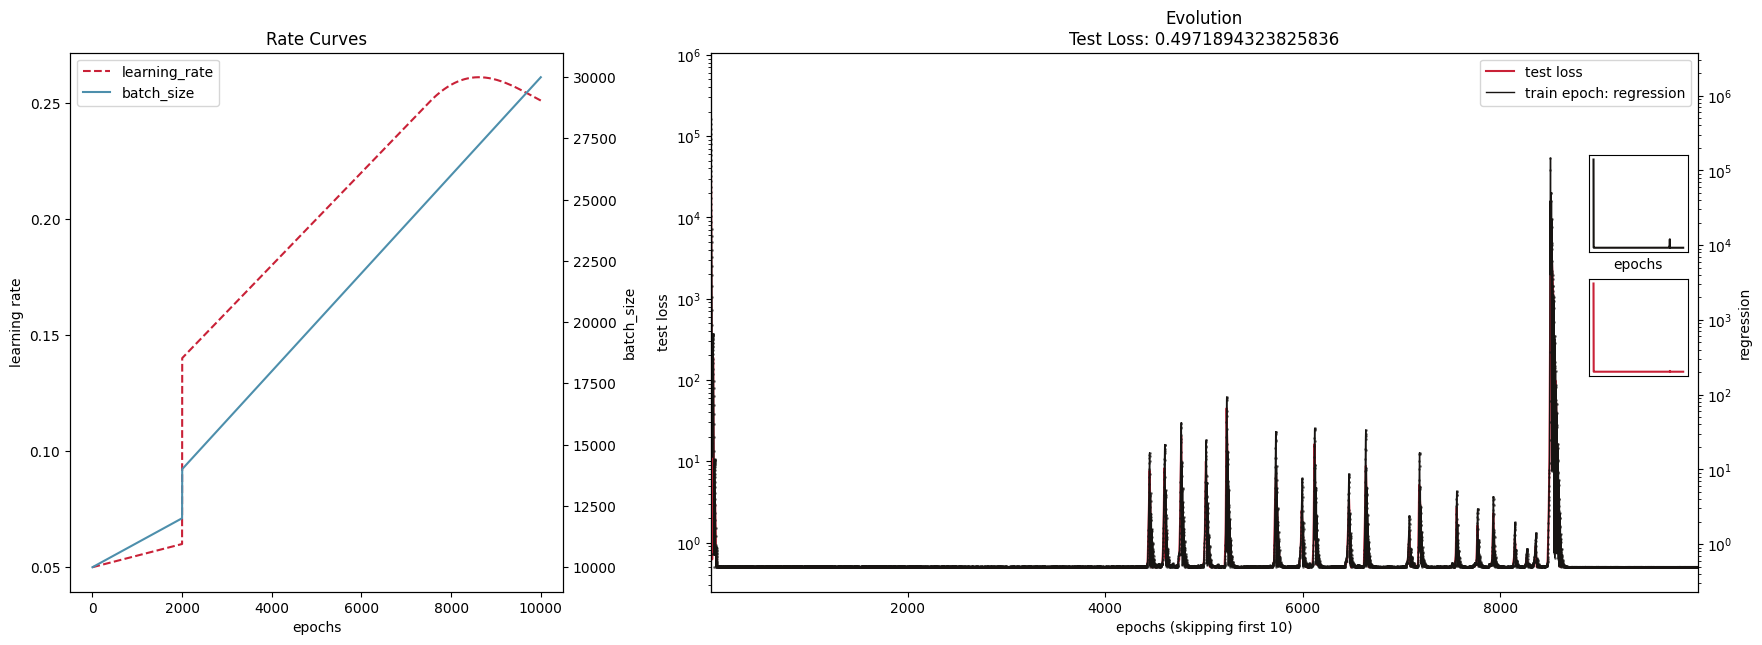

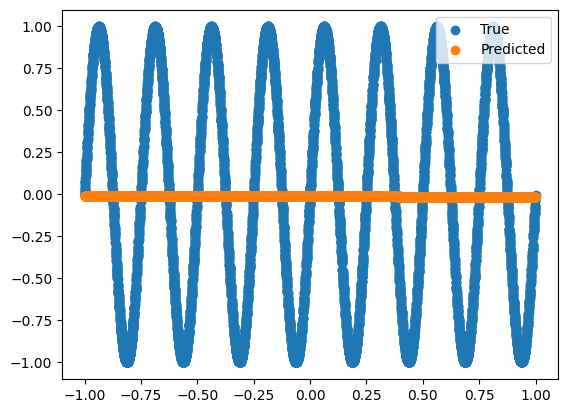

In [16]:
train_y,test_y = update_y(Ys1)
D.epochs = 10000

act = [lambda x: math.exp(-1)*torch.pow(torch.abs(x),1/math.sqrt(n*2)) for n in dnn_sizes] # std 1, 1 -> sqrt(2), (accounting for number of samples)
def setup(x):
     x.data = torch.exp(3+torch.minimum(torch.randn(x.size(), device=x.device) - 3,0.0*x)) # mean 0 , std 1, capped at 3sigma at top.
     return x
ins = [lambda x: setup(x)]*len(dnn_sizes)
# ins[0] = lambda x: torch.nn.init.constant_(x, 30)

net = DNN(device, dnn_sizes, opttype=opt, act = act, bias=False, initializers=ins) # expect 1.6% error rate
report = D.train(net, torch.exp(0.5*train_X), train_y, test_X, test_y, start_batch_size=10000) # input distribution lognormal with mean 0 and std 1
ecran(net, test_X, test_y, report, classification=False)
plt.scatter(test_X.detach().cpu().numpy(),test_y.detach().cpu().numpy(),label='True')
plt.scatter(test_X.detach().cpu().numpy(),net(torch.exp(0.5*test_X)).detach().cpu().numpy(),label='Predicted')
plt.legend()
plt.show()
D.epochs = 1000

100%|██████████| 1000/1000 [00:05<00:00, 176.96it/s]


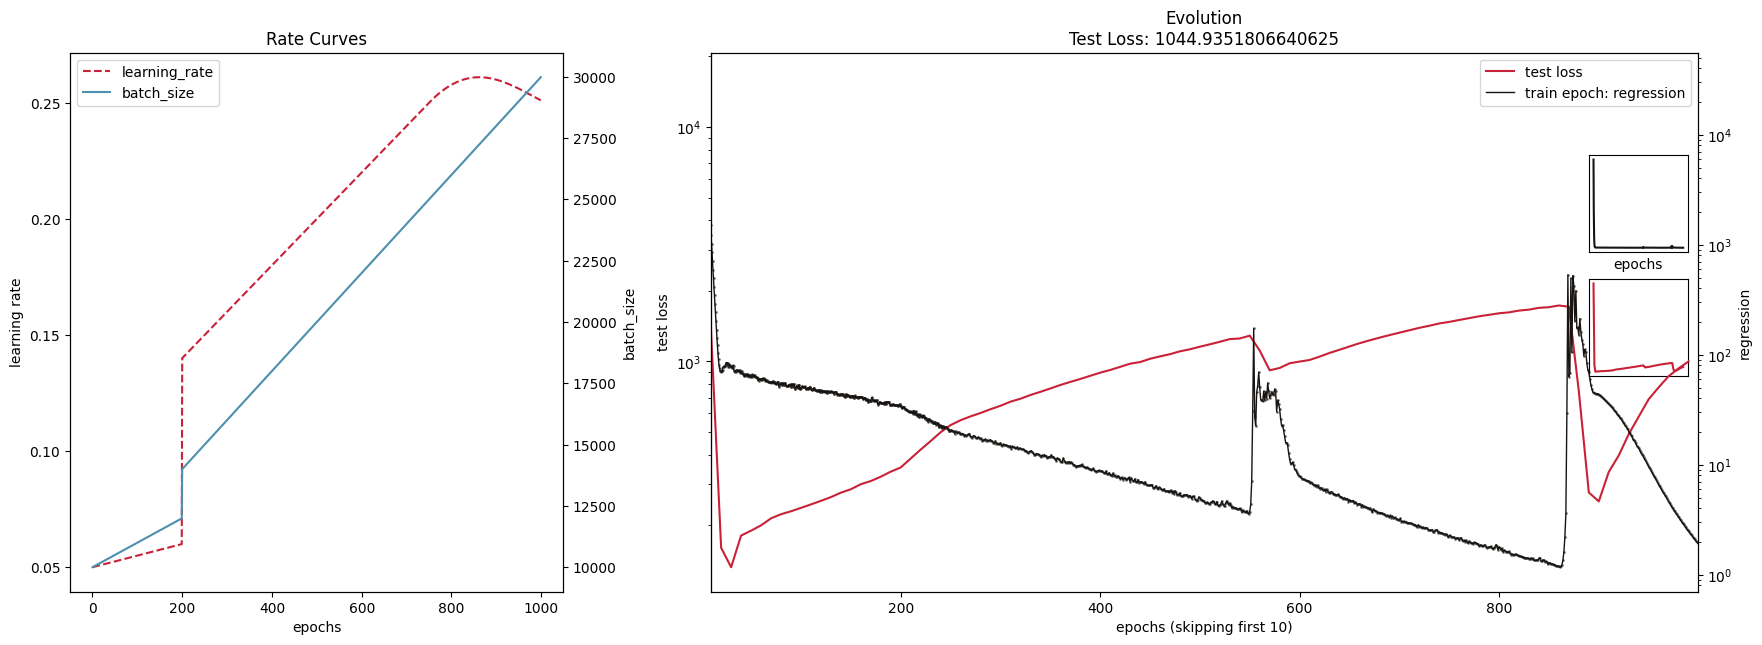

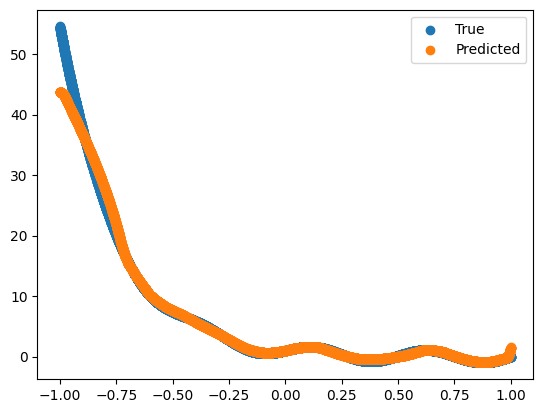

In [ ]:
train_y,test_y = update_y(Ys2)

act = [lambda x: math.exp(-1)*torch.pow(torch.abs(x),1/math.sqrt(n*2)) for n in dnn_sizes] # std 1, 1 -> sqrt(2), (accounting for number of samples)
def setup(x):
     x.data = torch.exp(3+torch.minimum(torch.randn(x.size(), device=x.device) - 3,0.0*x)) # mean 0 , std 1, capped at 3sigma at top.
     return x
ins = [lambda x: setup(x)]*len(dnn_sizes)
# ins[0] = lambda x: torch.nn.init.constant_(x, 30)

net = DNN(device, dnn_sizes, opttype=opt, act = act, bias=True, initializers=ins) # expect 1.6% error rate
report = D.train(net, torch.exp(0.5*train_X), train_y, test_X, test_y, start_batch_size=10000) # input distribution lognormal with mean 0 and std 1
ecran(net, test_X, test_y, report, classification=False)
plt.scatter(test_X.detach().cpu().numpy(),test_y.detach().cpu().numpy(),label='True')
plt.scatter(test_X.detach().cpu().numpy(),net(torch.exp(0.5*test_X)).detach().cpu().numpy(),label='Predicted')
plt.legend()
plt.show()

# e^-|x| DNN

100%|██████████| 1000/1000 [00:05<00:00, 189.84it/s]


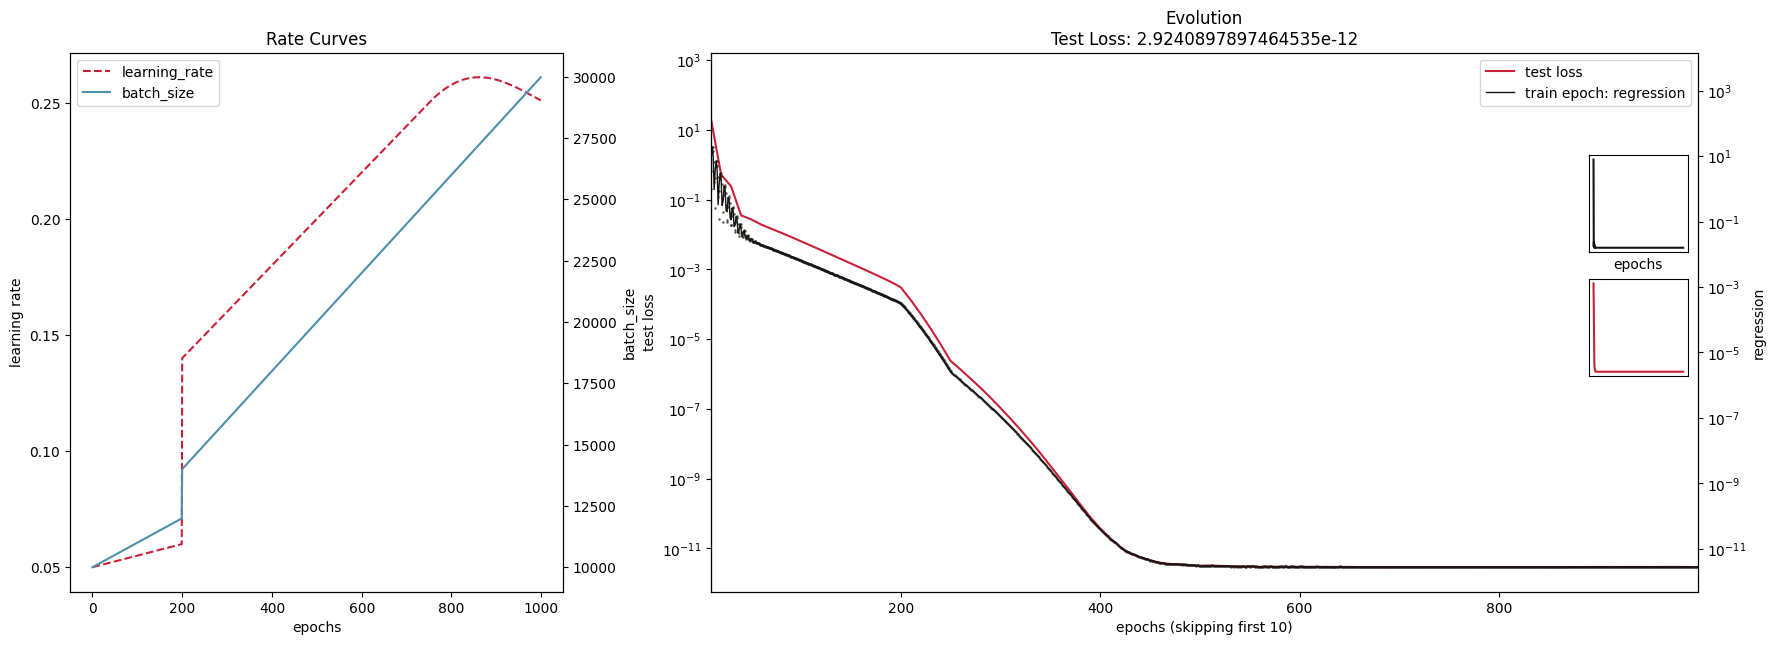

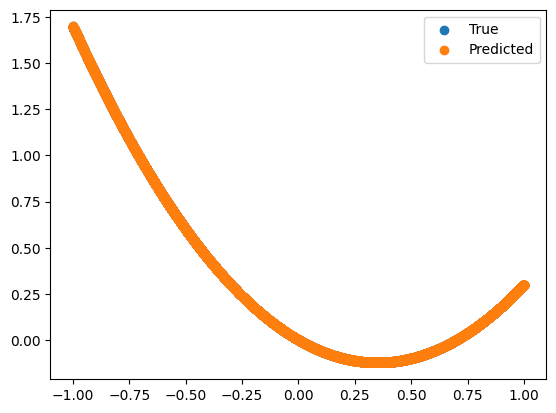

In [28]:
train_y,test_y = update_y(Ys0)

act = lambda x: math.pow(2.0,-10/3)*torch.pow(x,2) # std 1, 1 -> sqrt(2), (accounting for number of samples)
def setup0(x,n):
     x.data = 3*math.sqrt(1/n) * (2*torch.rand(x.size(), device=x.device)-1) 
     return x
def setup(x,n):
     x.data = math.sqrt(3/n) * (2*torch.rand(x.size(), device=x.device)-1) 
     return x
ins = [lambda x: setup(x,n) for n in dnn_sizes]
ins[0] = lambda x: setup0(x,dnn_sizes[0])
# ins[0] = lambda x: torch.nn.init.constant_(x, 30)

net = DNN(device, dnn_sizes, opttype=opt, act = act, bias=True, initializers=ins) # expect 1.6% error rate
report = D.train(net, train_X, train_y, test_X, test_y, start_batch_size=10000) 
ecran(net, test_X, test_y, report, classification=False)
plt.scatter(test_X.detach().cpu().numpy(),test_y.detach().cpu().numpy(),label='True')
plt.scatter(test_X.detach().cpu().numpy(),net(test_X).detach().cpu().numpy(),label='Predicted')
plt.legend()
plt.show()

100%|██████████| 1000/1000 [00:06<00:00, 161.95it/s]


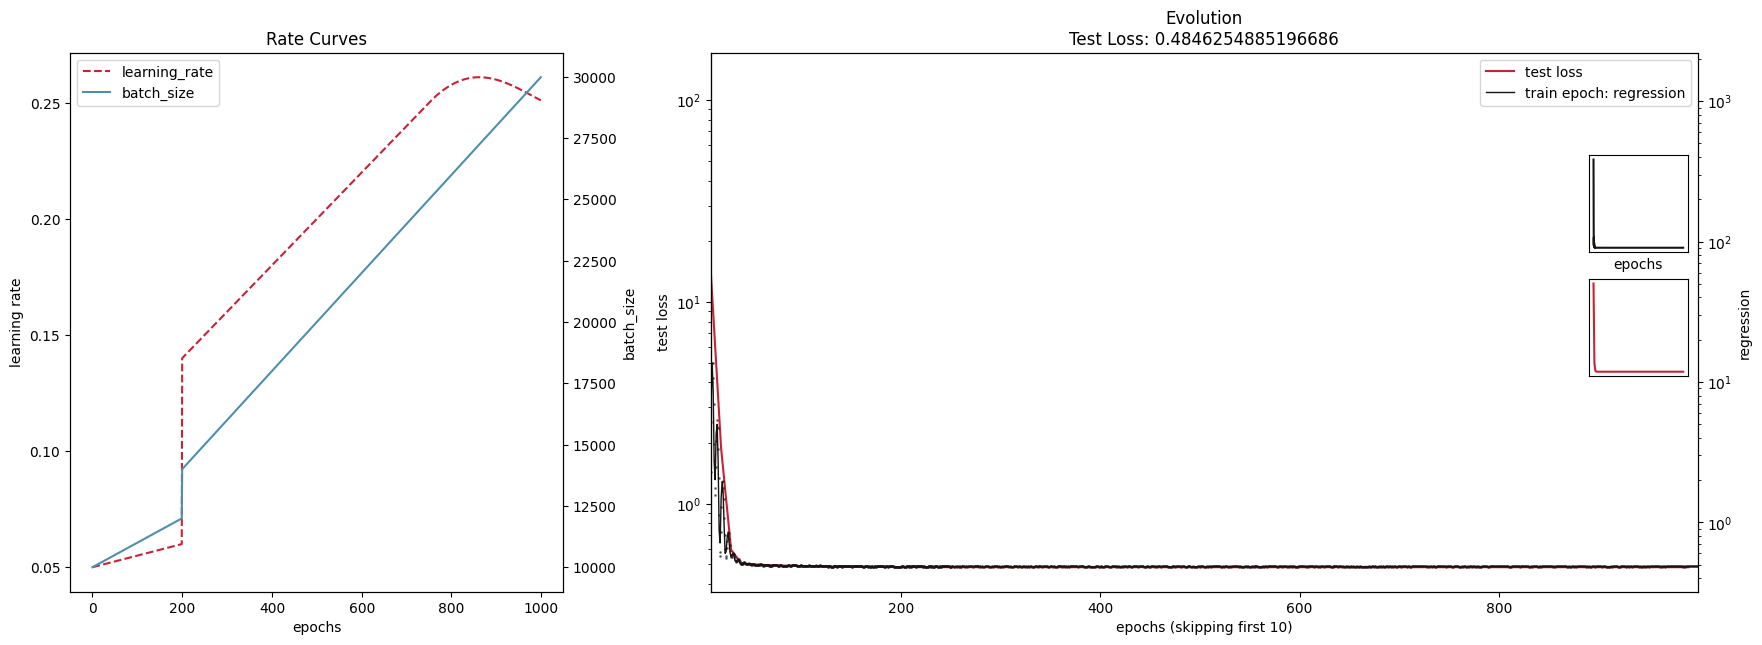

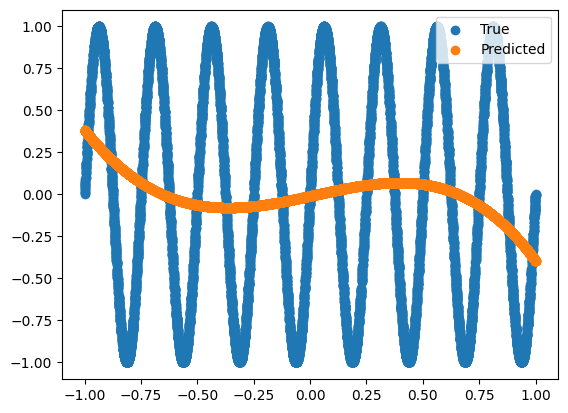

In [7]:
train_y,test_y = update_y(Ys1)

act = lambda x: math.pow(2.0,-10/3)*torch.pow(x,2)  # std 1, 1 -> sqrt(2), (accounting for number of samples)
def setup0(x,n):
     x.data = 3*math.sqrt(1/n) * (2*torch.rand(x.size(), device=x.device)-1) 
     return x
def setup(x,n):
     x.data = math.sqrt(3/n) * (2*torch.rand(x.size(), device=x.device)-1) 
     return x
ins = [lambda x: setup(x,n) for n in dnn_sizes]
ins[0] = lambda x: setup0(x,dnn_sizes[0])
# ins[0] = lambda x: torch.nn.init.constant_(x, 30)

net = DNN(device, dnn_sizes, opttype=opt, act = act, bias=True, initializers=ins) # expect 1.6% error rate
report = D.train(net, train_X, train_y, test_X, test_y, start_batch_size=10000) # input distribution lognormal with mean 0 and std 1
ecran(net, test_X, test_y, report, classification=False)
plt.scatter(test_X.detach().cpu().numpy(),test_y.detach().cpu().numpy(),label='True')
plt.scatter(test_X.detach().cpu().numpy(),net(test_X).detach().cpu().numpy(),label='Predicted')
plt.legend()
plt.show()

100%|██████████| 1000/1000 [00:05<00:00, 182.31it/s]


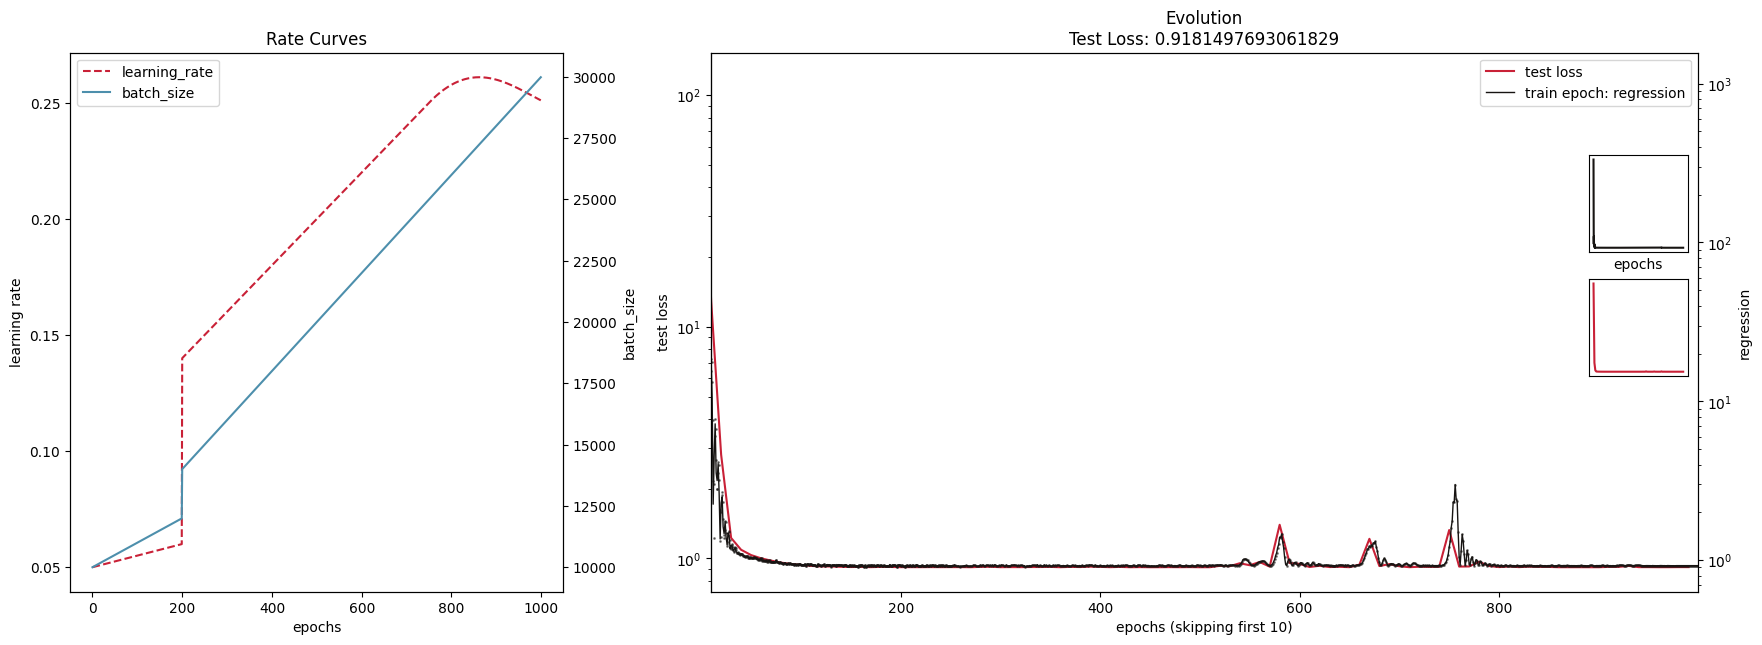

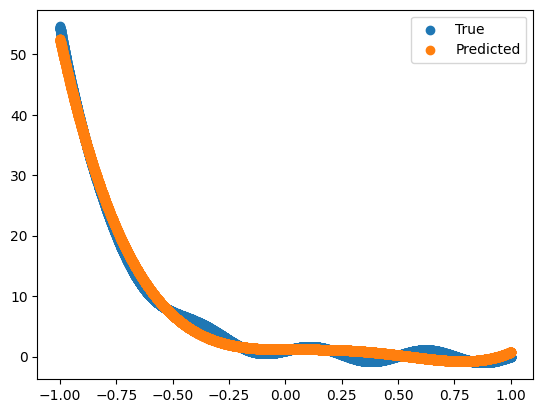

In [8]:
train_y,test_y = update_y(Ys2)

act = lambda x: math.pow(2.0,-10/3)*torch.pow(x,2) # std 1, 1 -> sqrt(2), (accounting for number of samples)
def setup0(x,n):
     x.data = 3*math.sqrt(1/n) * (2*torch.rand(x.size(), device=x.device)-1) 
     return x
def setup(x,n):
     x.data = math.sqrt(3/n) * (2*torch.rand(x.size(), device=x.device)-1) 
     return x
ins = [lambda x: setup(x,n) for n in dnn_sizes]
ins[0] = lambda x: setup0(x,dnn_sizes[0])
# ins[0] = lambda x: torch.nn.init.constant_(x, 30)

net = DNN(device, dnn_sizes, opttype=opt, act = act, bias=True, initializers=ins) # expect 1.6% error rate
report = D.train(net, train_X, train_y, test_X, test_y, start_batch_size=10000) # input distribution lognormal with mean 0 and std 1
ecran(net, test_X, test_y, report, classification=False)
plt.scatter(test_X.detach().cpu().numpy(),test_y.detach().cpu().numpy(),label='True')
plt.scatter(test_X.detach().cpu().numpy(),net(test_X).detach().cpu().numpy(),label='Predicted')
plt.legend()
plt.show()

In [9]:
# phaseDNN style

100%|██████████| 1000/1000 [00:05<00:00, 193.92it/s]


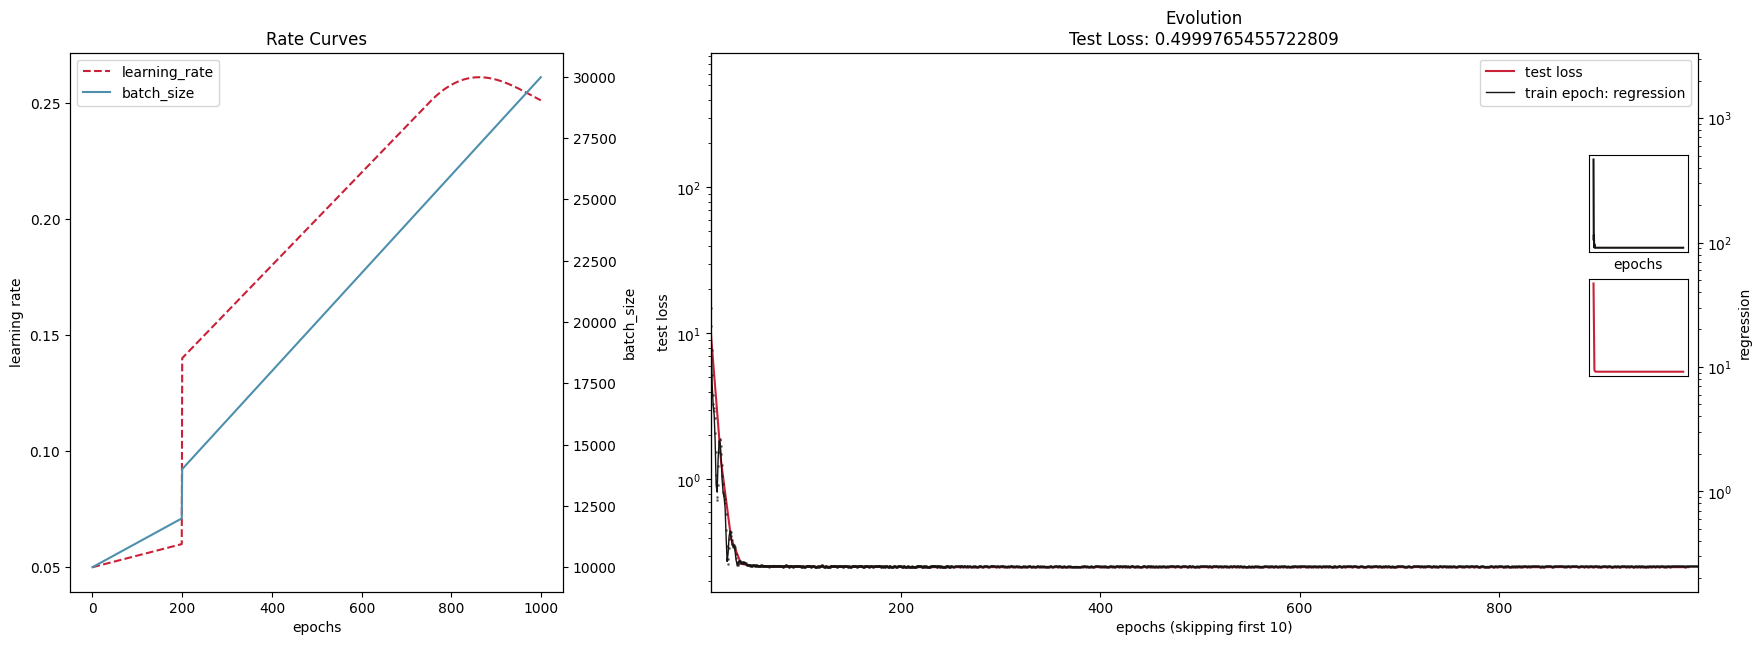

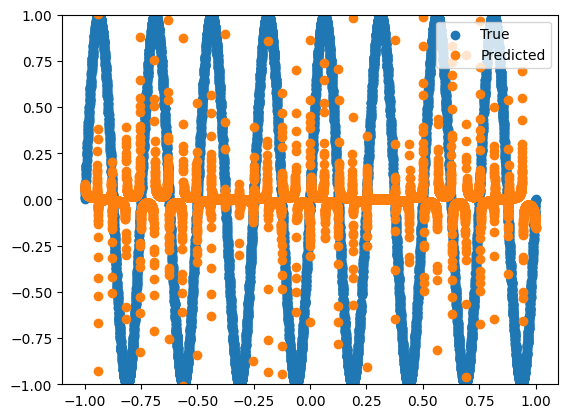

In [13]:
train_y,test_y = update_y(Ys1)

adj = lambda x,y: y*torch.sin(50*x)
inv_adj = lambda x,y: y/torch.sin(50*x)

act = lambda x: math.pow(2.0,-10/3)*torch.pow(x,2)  # std 1, 1 -> sqrt(2), (accounting for number of samples)
def setup0(x,n):
     x.data = 3*math.sqrt(1/n) * (2*torch.rand(x.size(), device=x.device)-1) 
     return x
def setup(x,n):
     x.data = math.sqrt(3/n) * (2*torch.rand(x.size(), device=x.device)-1) 
     return x
ins = [lambda x: setup(x,n) for n in dnn_sizes]
ins[0] = lambda x: setup0(x,dnn_sizes[0])
# ins[0] = lambda x: torch.nn.init.constant_(x, 30)

net = DNN(device, dnn_sizes, opttype=opt, act = act, bias=True, initializers=ins) # expect 1.6% error rate
report = D.train(net, train_X, adj(train_X,train_y), test_X, adj(test_X,test_y), start_batch_size=10000) # input distribution lognormal with mean 0 and std 1
ecran(net, test_X, test_y, report, classification=False)
plt.scatter(test_X.detach().cpu().numpy(),test_y.detach().cpu().numpy(),label='True')
plt.scatter(test_X.detach().cpu().numpy(),inv_adj(test_X,net(test_X)).detach().cpu().numpy(),label='Predicted')
plt.ylim(-1,1)
plt.legend()
plt.show()

# e^-(x^4)/2 DNN

100%|██████████| 1000/1000 [00:06<00:00, 146.43it/s]


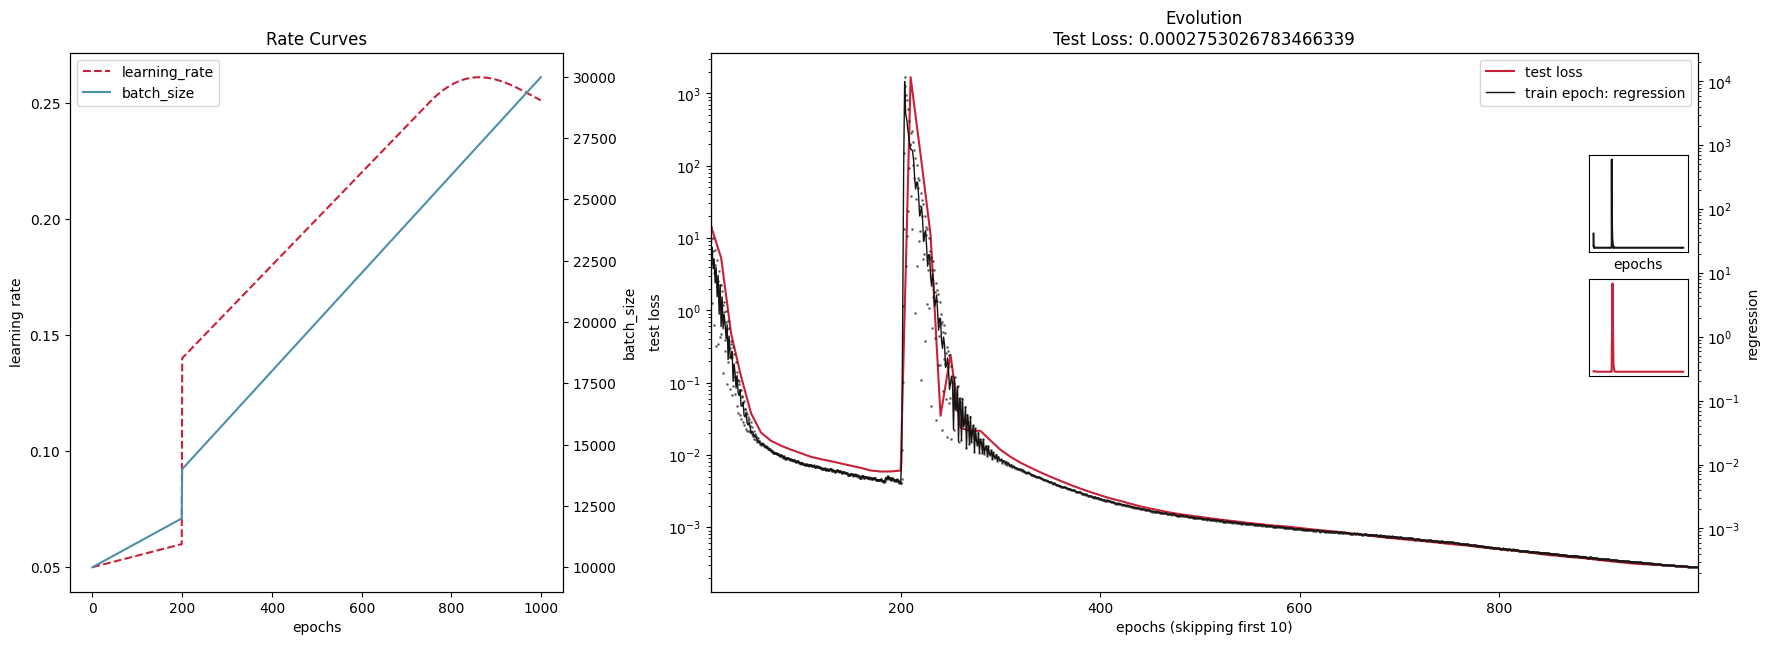

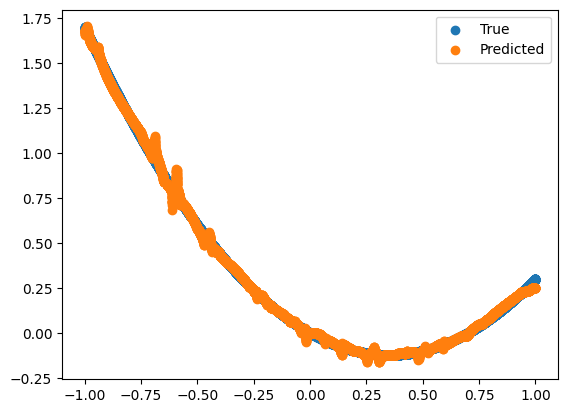

In [15]:

train_y,test_y = update_y(Ys0)

act = lambda x: 1.13374*torch.pow(torch.abs(x),0.5) # std 1, 1 -> sqrt(2), (accounting for number of samples)
def setup0(x,n):
     x.data = 3*math.sqrt(1/n) * (2*torch.rand(x.size(), device=x.device)-1) 
     return x
def setup(x,n):
     x.data = math.sqrt(3/n) * (2*torch.rand(x.size(), device=x.device)-1) 
     return x
ins = [lambda x: setup(x,n) for n in dnn_sizes]
ins[0] = lambda x: setup0(x,dnn_sizes[0])
# ins[0] = lambda x: torch.nn.init.constant_(x, 30)

net = DNN(device, dnn_sizes, opttype=opt, act = act, bias=True, initializers=ins) # expect 1.6% error rate
report = D.train(net, train_X, train_y, test_X, test_y, start_batch_size=10000) 
ecran(net, test_X, test_y, report, classification=False)
plt.scatter(test_X.detach().cpu().numpy(),test_y.detach().cpu().numpy(),label='True')
plt.scatter(test_X.detach().cpu().numpy(),net(test_X).detach().cpu().numpy(),label='Predicted')
plt.legend()
plt.show()

100%|██████████| 1000/1000 [00:06<00:00, 153.41it/s]


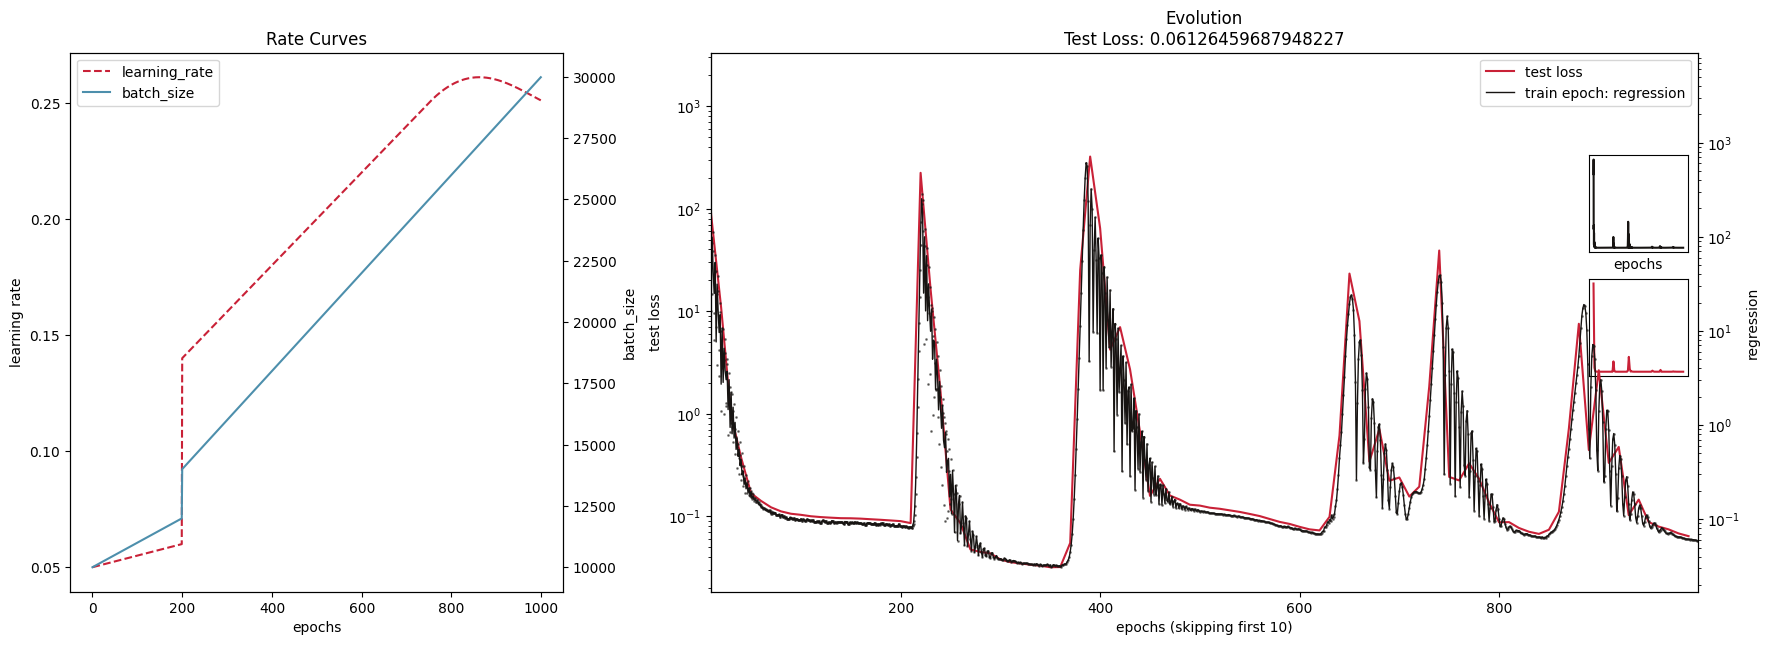

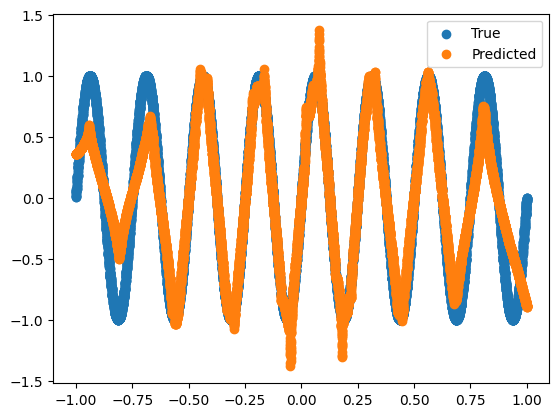

In [16]:
train_y,test_y = update_y(Ys1)

act = lambda x: 1.13374*torch.pow(torch.abs(x),0.5) # std 1, 1 -> sqrt(2), (accounting for number of samples)
def setup0(x,n):
     x.data = 3*math.sqrt(1/n) * (2*torch.rand(x.size(), device=x.device)-1) 
     return x
def setup(x,n):
     x.data = math.sqrt(3/n) * (2*torch.rand(x.size(), device=x.device)-1) 
     return x
ins = [lambda x: setup(x,n) for n in dnn_sizes]
ins[0] = lambda x: setup0(x,dnn_sizes[0])
# ins[0] = lambda x: torch.nn.init.constant_(x, 30)

net = DNN(device, dnn_sizes, opttype=opt, act = act, bias=True, initializers=ins) # expect 1.6% error rate
report = D.train(net, train_X, train_y, test_X, test_y, start_batch_size=10000) 
ecran(net, test_X, test_y, report, classification=False)
plt.scatter(test_X.detach().cpu().numpy(),test_y.detach().cpu().numpy(),label='True')
plt.scatter(test_X.detach().cpu().numpy(),net(test_X).detach().cpu().numpy(),label='Predicted')
plt.legend()
plt.show()

100%|██████████| 1000/1000 [00:05<00:00, 173.81it/s]


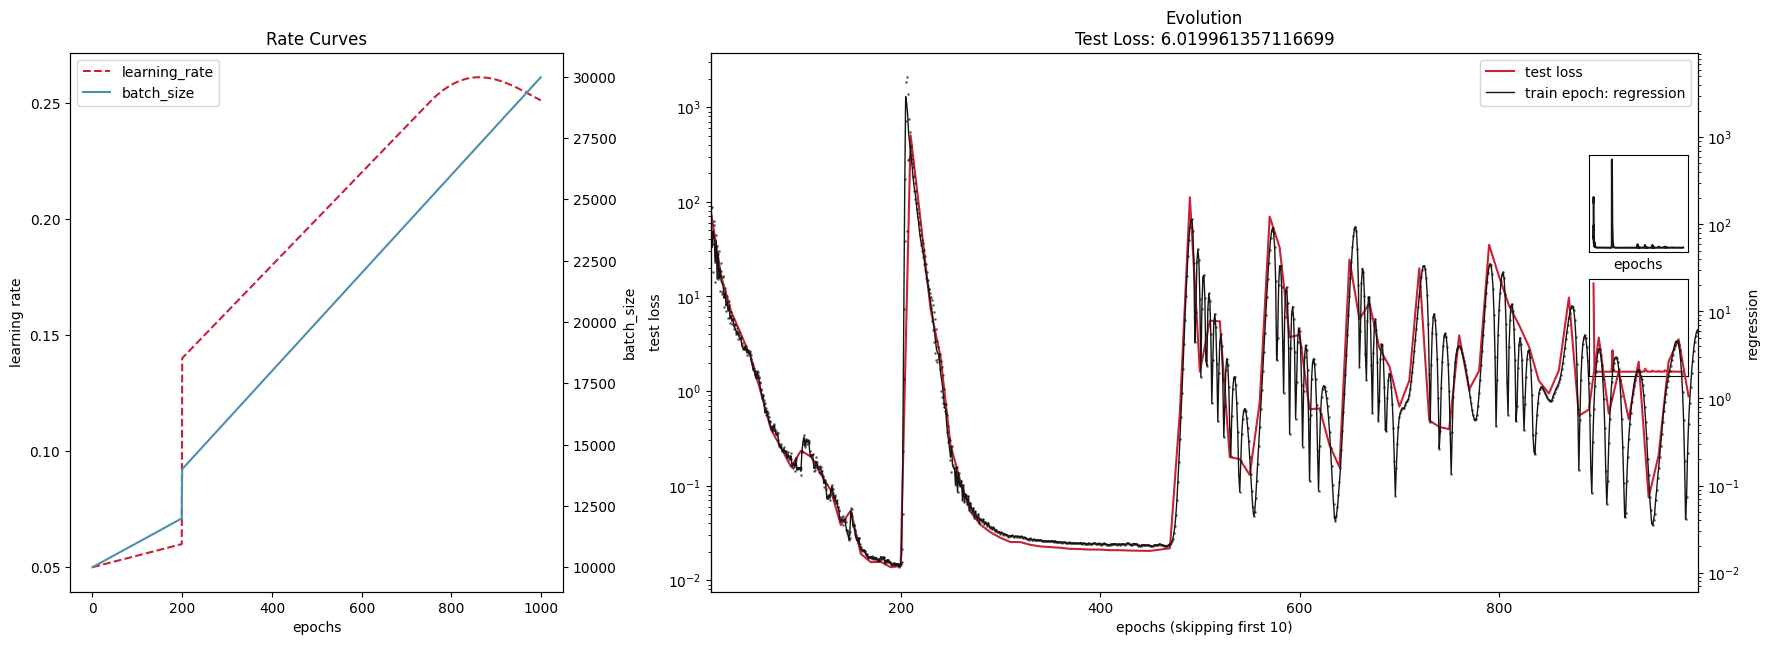

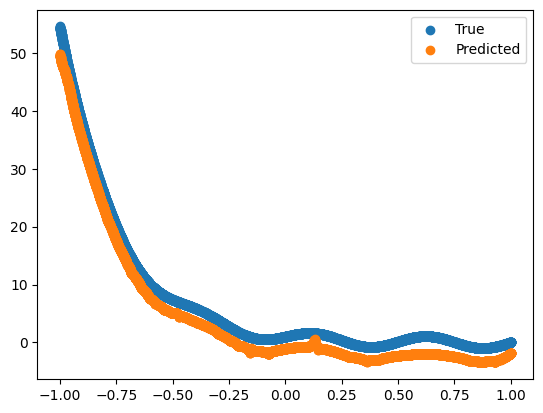

In [17]:
train_y,test_y = update_y(Ys2)

act = lambda x: 1.13374*torch.pow(torch.abs(x),0.5) # std 1, 1 -> sqrt(2), (accounting for number of samples)
def setup0(x,n):
     x.data = 3*math.sqrt(1/n) * (2*torch.rand(x.size(), device=x.device)-1) 
     return x
def setup(x,n):
     x.data = math.sqrt(3/n) * (2*torch.rand(x.size(), device=x.device)-1) 
     return x
ins = [lambda x: setup(x,n) for n in dnn_sizes]
ins[0] = lambda x: setup0(x,dnn_sizes[0])
# ins[0] = lambda x: torch.nn.init.constant_(x, 30)

net = DNN(device, dnn_sizes, opttype=opt, act = act, bias=True, initializers=ins) # expect 1.6% error rate
report = D.train(net, train_X, train_y, test_X, test_y, start_batch_size=10000) 
ecran(net, test_X, test_y, report, classification=False)
plt.scatter(test_X.detach().cpu().numpy(),test_y.detach().cpu().numpy(),label='True')
plt.scatter(test_X.detach().cpu().numpy(),net(test_X).detach().cpu().numpy(),label='Predicted')
plt.legend()
plt.show()

## bad example

100%|██████████| 1000/1000 [00:05<00:00, 178.16it/s]


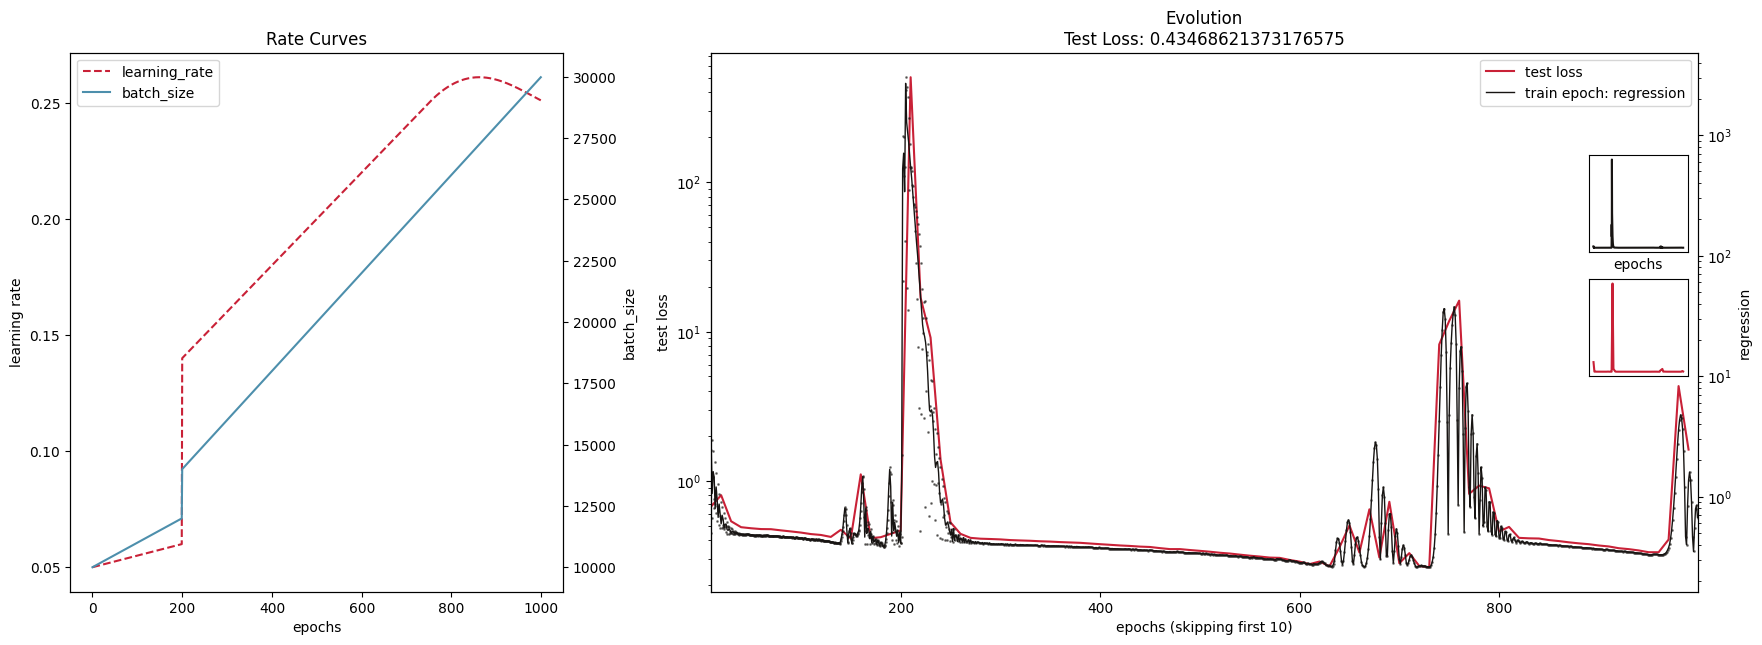

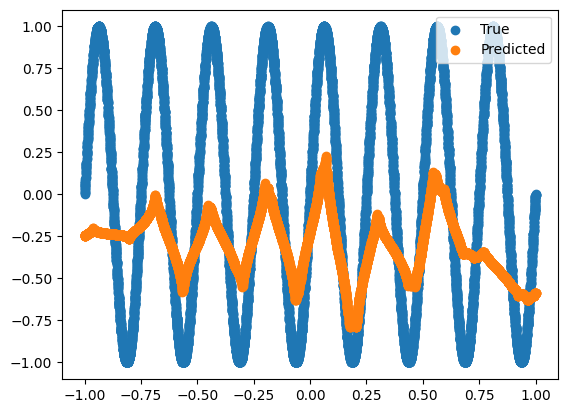

In [24]:
train_y,test_y = update_y(Ys1)

act = lambda x: 1.13374*torch.pow(torch.abs(x),0.5) # std 1, 1 -> sqrt(2), (accounting for number of samples)
# ins[0] = lambda x: torch.nn.init.constant_(x, 30)

net = DNN(device, dnn_sizes, opttype=opt, act = act, bias=True) # expect 1.6% error rate
report = D.train(net, train_X, train_y, test_X, test_y, start_batch_size=10000) 
ecran(net, test_X, test_y, report, classification=False)
plt.scatter(test_X.detach().cpu().numpy(),test_y.detach().cpu().numpy(),label='True')
plt.scatter(test_X.detach().cpu().numpy(),net(test_X).detach().cpu().numpy(),label='Predicted')
plt.legend()
plt.show()

## initialized DNN example

100%|██████████| 1000/1000 [00:06<00:00, 163.04it/s]


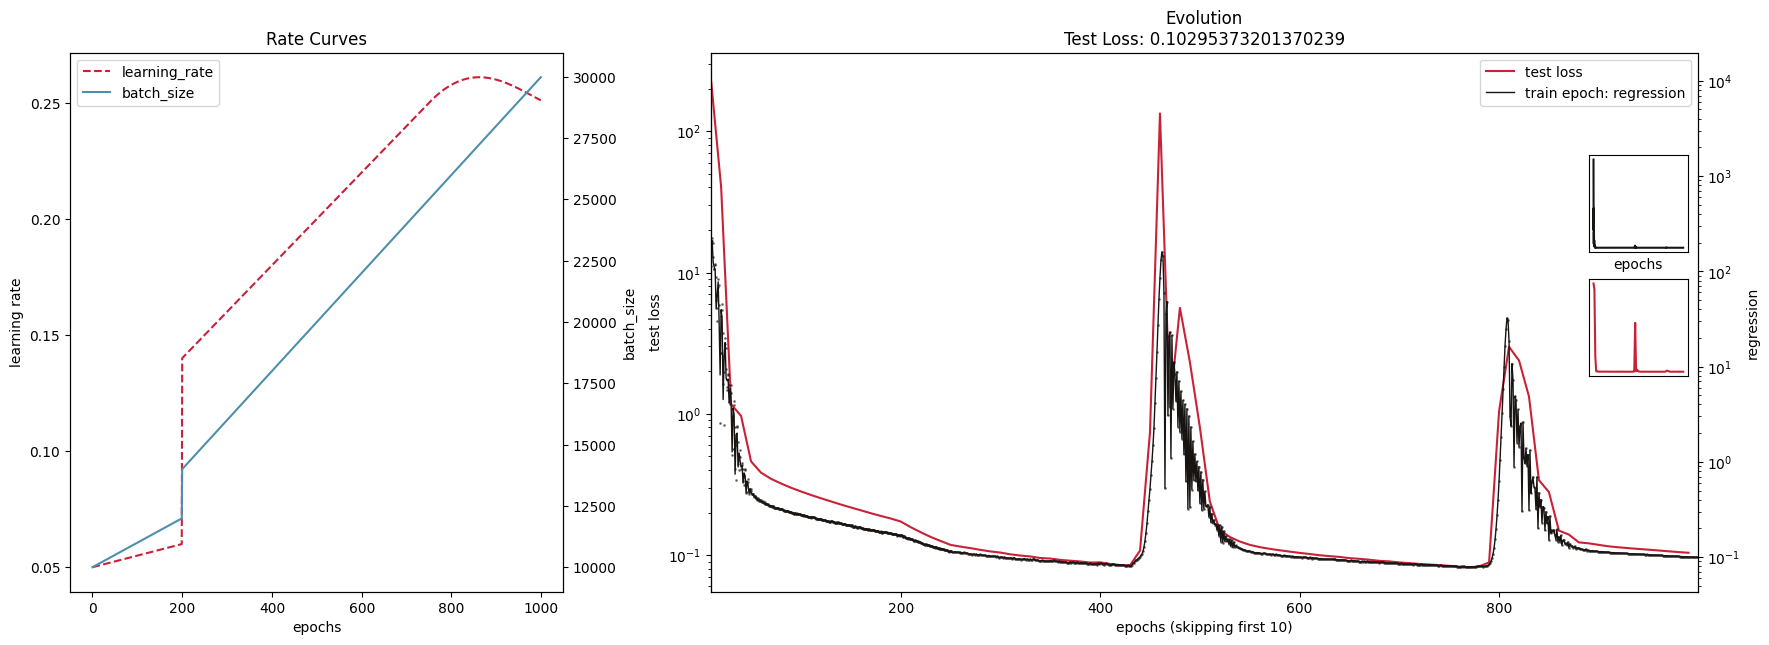

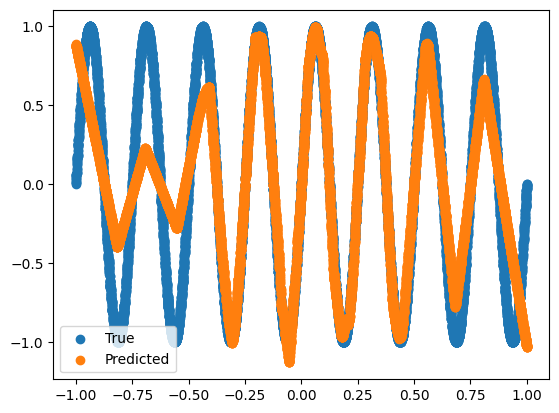

In [30]:
train_y,test_y = update_y(Ys1)

act = lambda x: torch.nn.functional.relu(x) # std 1, 1 -> sqrt(2), (accounting for number of samples)
def setup0(x,n):
     x.data = 3*math.sqrt(1/n) * (2*torch.rand(x.size(), device=x.device)-1) 
     return x
def setup(x,n):
     x.data = math.sqrt(3/n) * (2*torch.rand(x.size(), device=x.device)-1) 
     return x
ins = [lambda x: setup(x,n) for n in dnn_sizes]
ins[0] = lambda x: setup0(x,dnn_sizes[0])
# ins[0] = lambda x: torch.nn.init.constant_(x, 30)
net = DNN(device, dnn_sizes, opttype=opt, act = act, bias=True, initializers=ins) # expect 1.6% error rate
report = D.train(net, train_X, train_y, test_X, test_y, start_batch_size=10000) 
ecran(net, test_X, test_y, report, classification=False)
plt.scatter(test_X.detach().cpu().numpy(),test_y.detach().cpu().numpy(),label='True')
plt.scatter(test_X.detach().cpu().numpy(),net(test_X).detach().cpu().numpy(),label='Predicted')
plt.legend()
plt.show()

## uninitialized DNN example

100%|██████████| 1000/1000 [00:04<00:00, 205.96it/s]


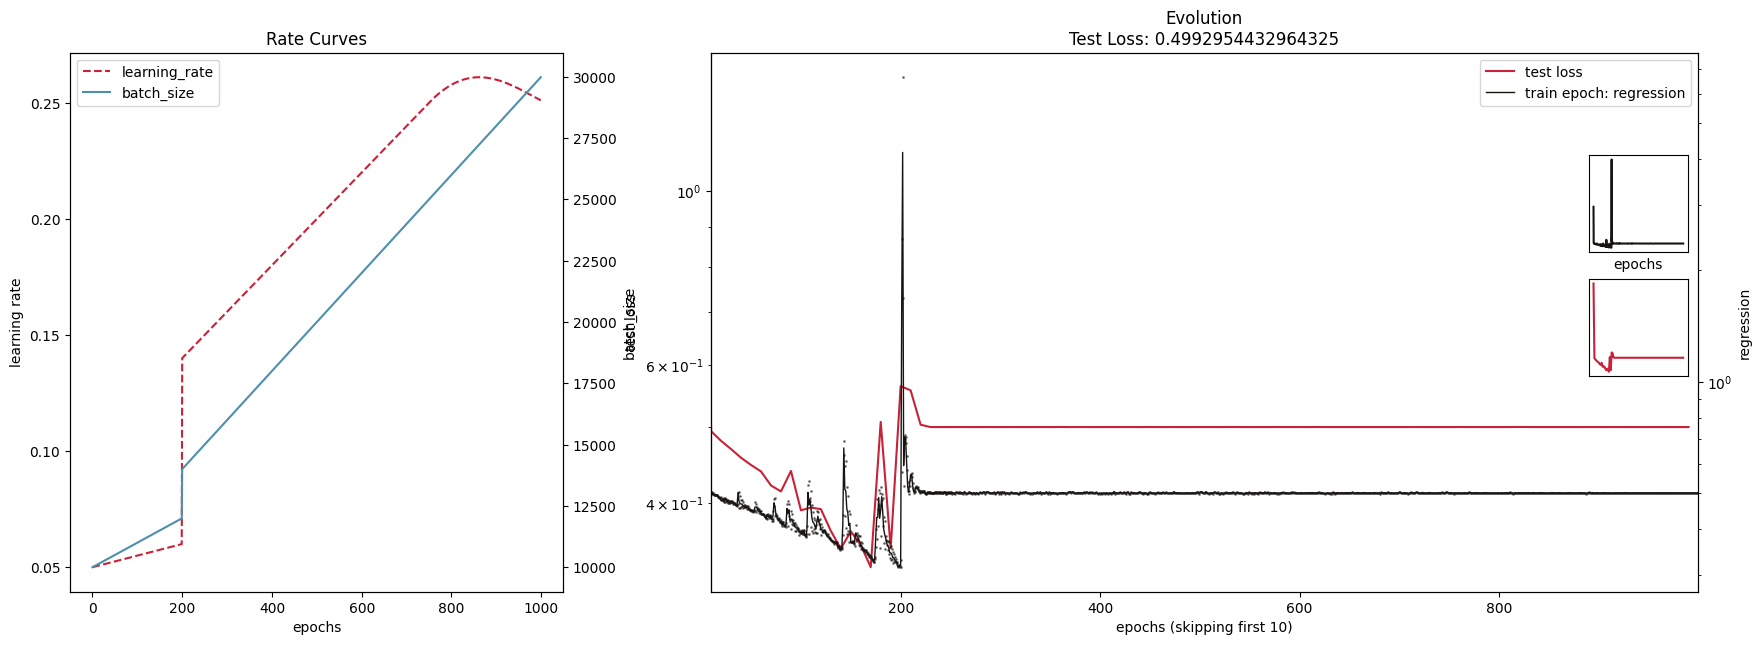

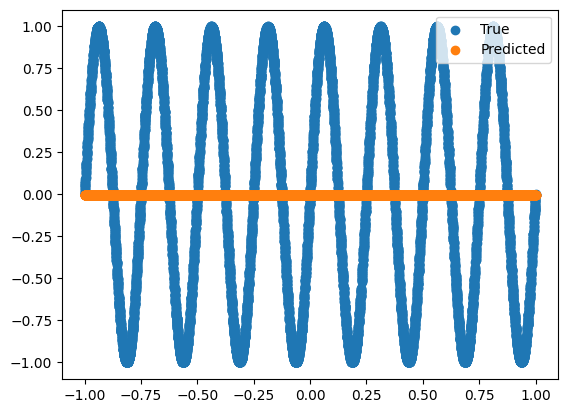

In [31]:
train_y,test_y = update_y(Ys1)

act = lambda x: torch.nn.functional.relu(x) # std 1, 1 -> sqrt(2), (accounting for number of samples)

# ins[0] = lambda x: torch.nn.init.constant_(x, 30)
net = DNN(device, dnn_sizes, opttype=opt, act = act, bias=True) # expect 1.6% error rate
report = D.train(net, train_X, train_y, test_X, test_y, start_batch_size=10000) 
ecran(net, test_X, test_y, report, classification=False)
plt.scatter(test_X.detach().cpu().numpy(),test_y.detach().cpu().numpy(),label='True')
plt.scatter(test_X.detach().cpu().numpy(),net(test_X).detach().cpu().numpy(),label='Predicted')
plt.legend()
plt.show()

100%|██████████| 1000/1000 [00:04<00:00, 239.49it/s]


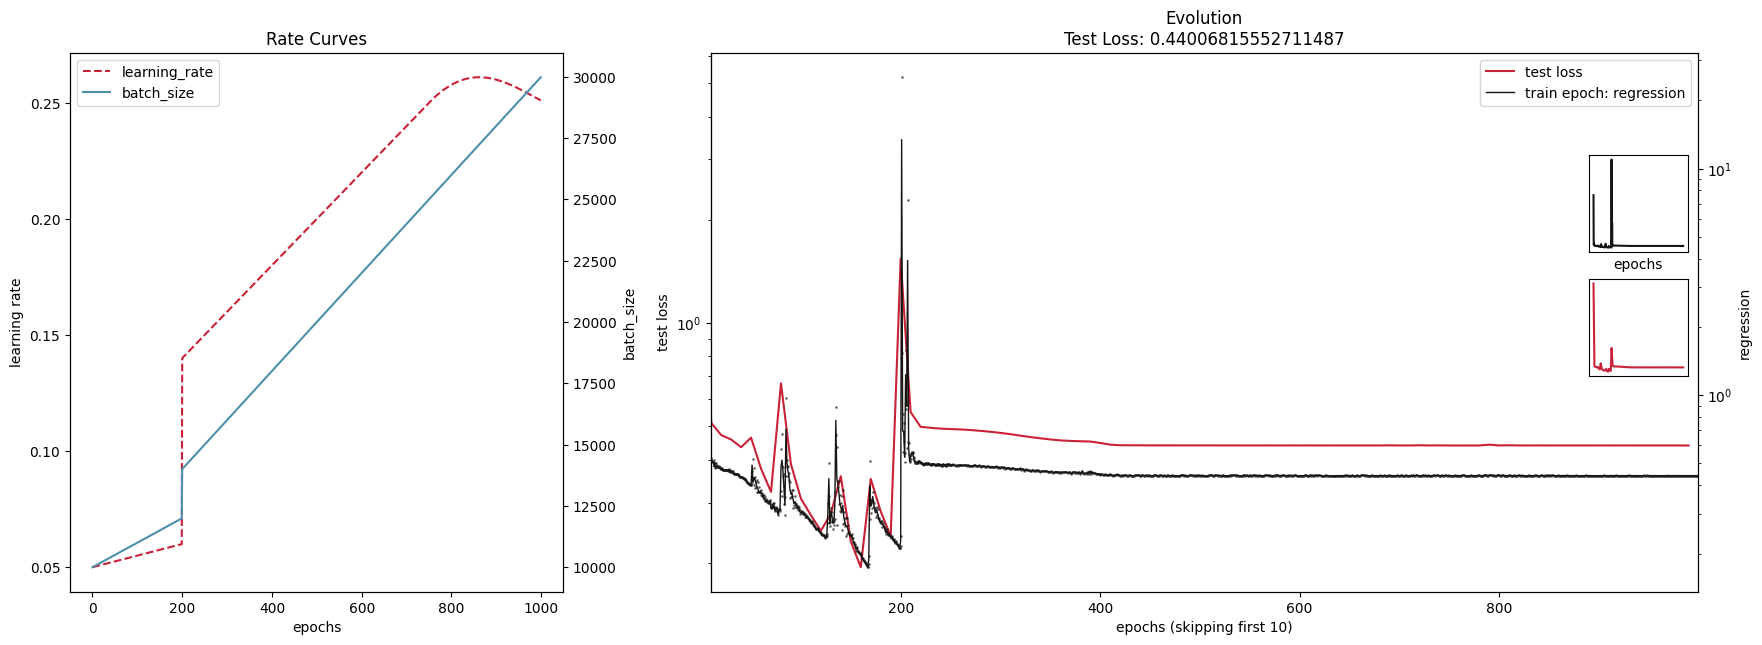

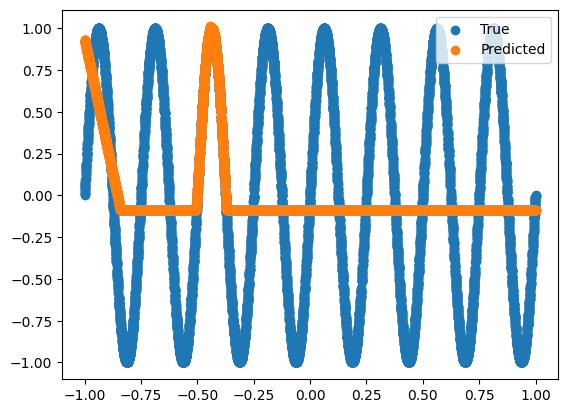

In [35]:
train_y,test_y = update_y(Ys1) 

# partial initialization

act = lambda x: torch.nn.functional.relu(x) # std 1, 1 -> sqrt(2), (accounting for number of samples)
def setup0(x,n):
     x.data = 3*math.sqrt(1/n) * (2*torch.rand(x.size(), device=x.device)-1) 
     return x
def setup(x,n):
    # skip
     return x
ins = [lambda x: setup(x,n) for n in dnn_sizes]
ins[0] = lambda x: setup0(x,dnn_sizes[0])

# ins[0] = lambda x: torch.nn.init.constant_(x, 30)
net = DNN(device, dnn_sizes, opttype=opt, act = act, bias=True, initializers=ins) # expect 1.6% error rate
report = D.train(net, train_X, train_y, test_X, test_y, start_batch_size=10000) 
ecran(net, test_X, test_y, report, classification=False)
plt.scatter(test_X.detach().cpu().numpy(),test_y.detach().cpu().numpy(),label='True')
plt.scatter(test_X.detach().cpu().numpy(),net(test_X).detach().cpu().numpy(),label='Predicted')
plt.legend()
plt.show()

100%|██████████| 1000/1000 [00:04<00:00, 233.26it/s]


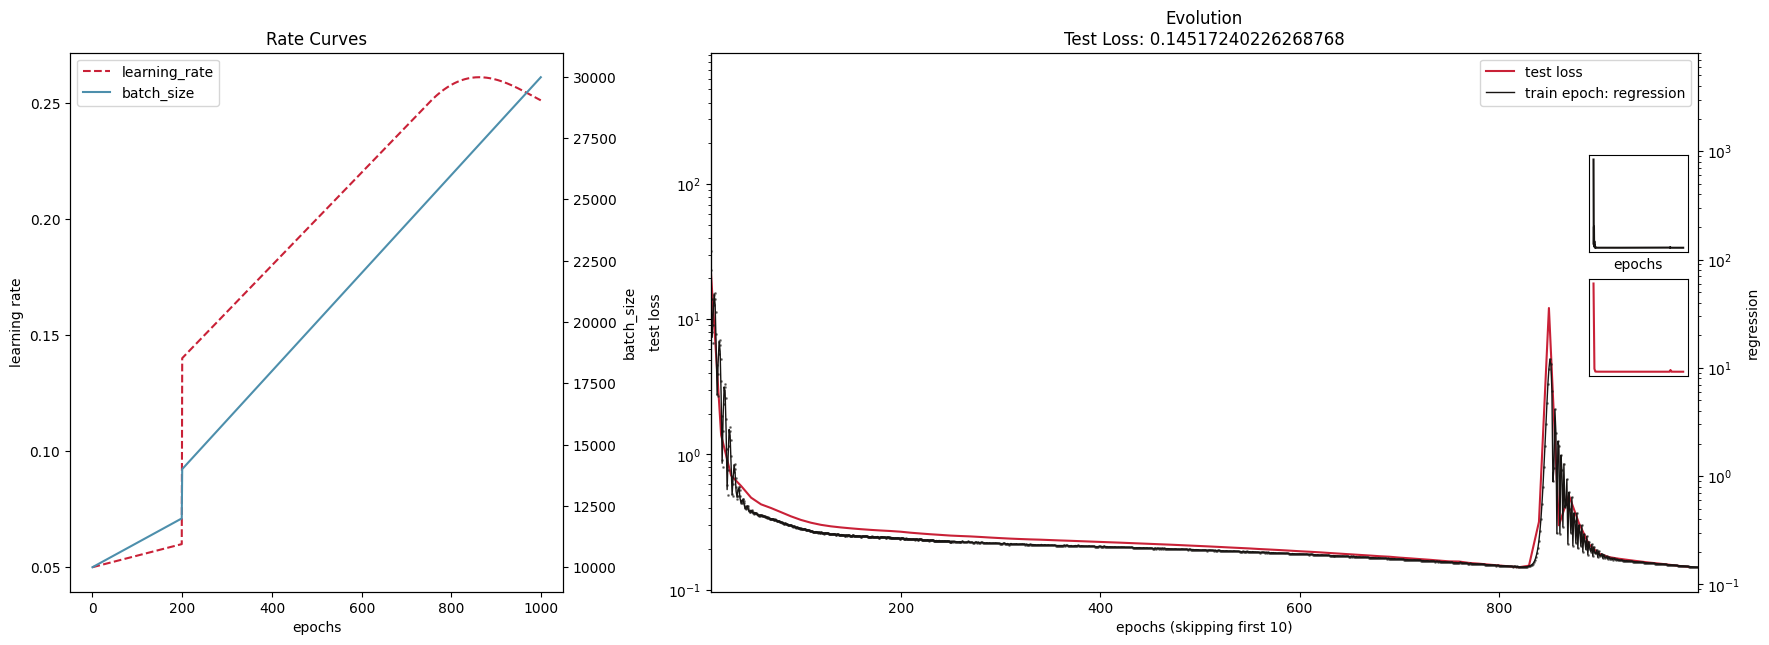

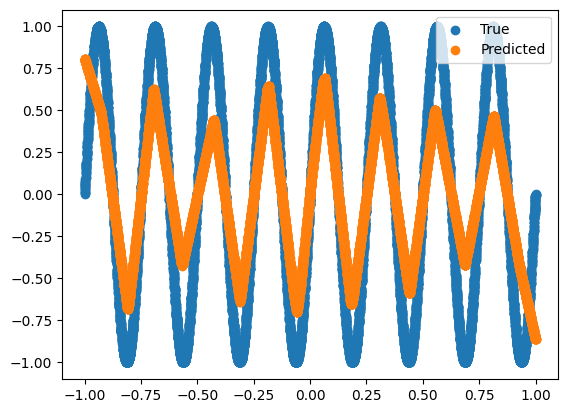

In [36]:
train_y,test_y = update_y(Ys1) 

# partial initialization

act = lambda x: torch.nn.functional.relu(x) # std 1, 1 -> sqrt(2), (accounting for number of samples)
def setup0(x,n):
     # x.data = 3*math.sqrt(1/n) * (2*torch.rand(x.size(), device=x.device)-1) 
     return x
def setup(x,n):
     x.data = math.sqrt(3/n) * (2*torch.rand(x.size(), device=x.device)-1) 
     return x
ins = [lambda x: setup(x,n) for n in dnn_sizes]
ins[0] = lambda x: setup0(x,dnn_sizes[0])

# ins[0] = lambda x: torch.nn.init.constant_(x, 30)
net = DNN(device, dnn_sizes, opttype=opt, act = act, bias=True,initializers=ins) # expect 1.6% error rate
report = D.train(net, train_X, train_y, test_X, test_y, start_batch_size=10000) 
ecran(net, test_X, test_y, report, classification=False)
plt.scatter(test_X.detach().cpu().numpy(),test_y.detach().cpu().numpy(),label='True')
plt.scatter(test_X.detach().cpu().numpy(),net(test_X).detach().cpu().numpy(),label='Predicted')
plt.legend()
plt.show()